In [1]:
!pip install gower scipy matplotlib seaborn

Computing Gower distance matrix...
Performing hierarchical clustering...


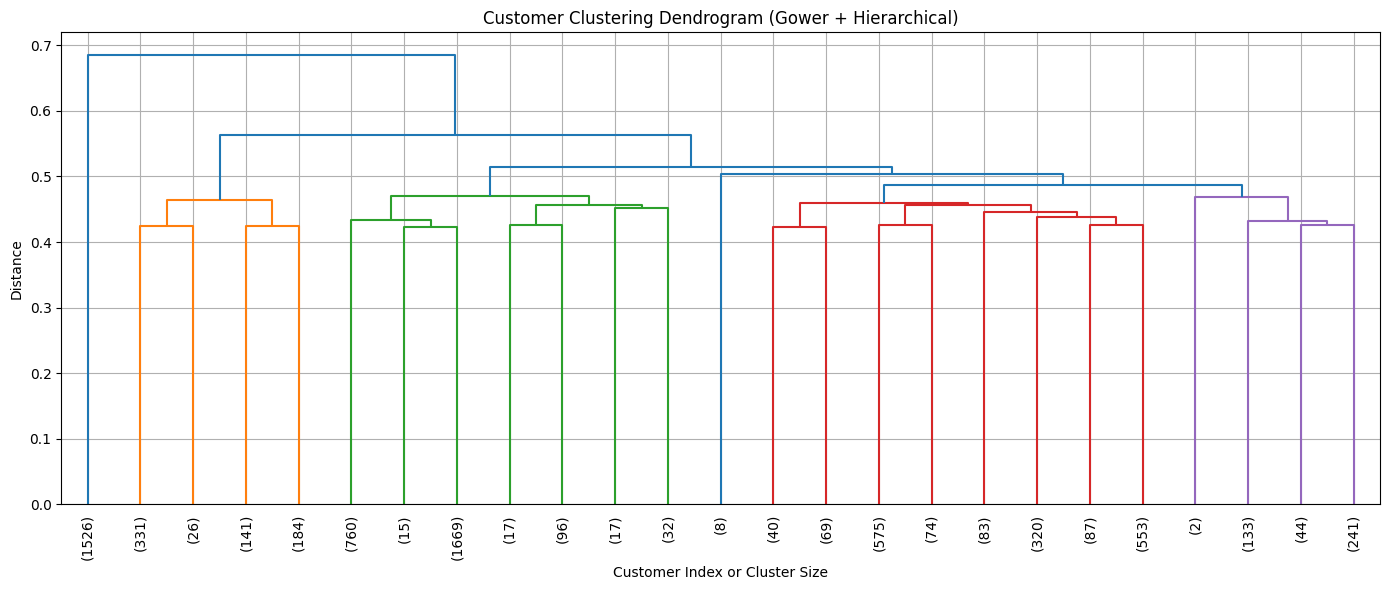


Clustering with k = 2
           gender       SeniorCitizen         Partner       Dependents        \
             mean count          mean count      mean count       mean count   
Cluster                                                                        
1        0.510485  1526      0.034076  1526  0.483617  1526   0.421363  1526   
2        0.503172  5517      0.197571  5517  0.482871  5517   0.265905  5517   

            tenure        ... PaperlessBilling       PaymentMethod        \
              mean count  ...             mean count          mean count   
Cluster                   ...                                              
1        30.547182  1526  ...         0.292267  1526      1.833552  1526   
2        32.875657  5517  ...         0.675186  5517      1.502628  5517   

        MonthlyCharges       TotalCharges           Churn        
                  mean count         mean count      mean count  
Cluster                                                        

In [2]:
import pandas as pd
import numpy as np
import gower
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import fcluster
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load dataset ---
df = pd.read_csv("/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv")
df = df.drop(columns=['customerID'])

# --- Encode categorical variables using LabelEncoder (for profiling only) ---
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
df_encoded = df.copy()
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

# --- Compute Gower distance ---
print("Computing Gower distance matrix...")
gower_matrix = gower.gower_matrix(df)

# Condensed form for linkage
gower_condensed = squareform(gower_matrix, checks=False)

# --- Hierarchical clustering ---
print("Performing hierarchical clustering...")
linkage_matrix = sch.linkage(gower_condensed, method='average')

# --- Dendrogram (optional) ---
plt.figure(figsize=(14, 6))
dendro = sch.dendrogram(linkage_matrix, truncate_mode='lastp', p=25, leaf_rotation=90, leaf_font_size=10)
plt.title("Customer Clustering Dendrogram (Gower + Hierarchical)")
plt.xlabel("Customer Index or Cluster Size")
plt.ylabel("Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Cluster assignment and save to CSV ---
for k in range(2, 6):
    print(f"\nClustering with k = {k}")
    cluster_labels = fcluster(linkage_matrix, t=k, criterion='maxclust')
    
    df_clustered = df_encoded.copy()
    df_clustered['Cluster'] = cluster_labels
    
    # Optional: print summary
    summary = df_clustered.groupby('Cluster').agg(['mean', 'count'])
    print(summary)
    
    # Save to CSV
    output_filename = f"clustered_customers_k{k}.csv"
    df_clustered.to_csv(output_filename, index=False)
    print(f"Saved: {output_filename}")


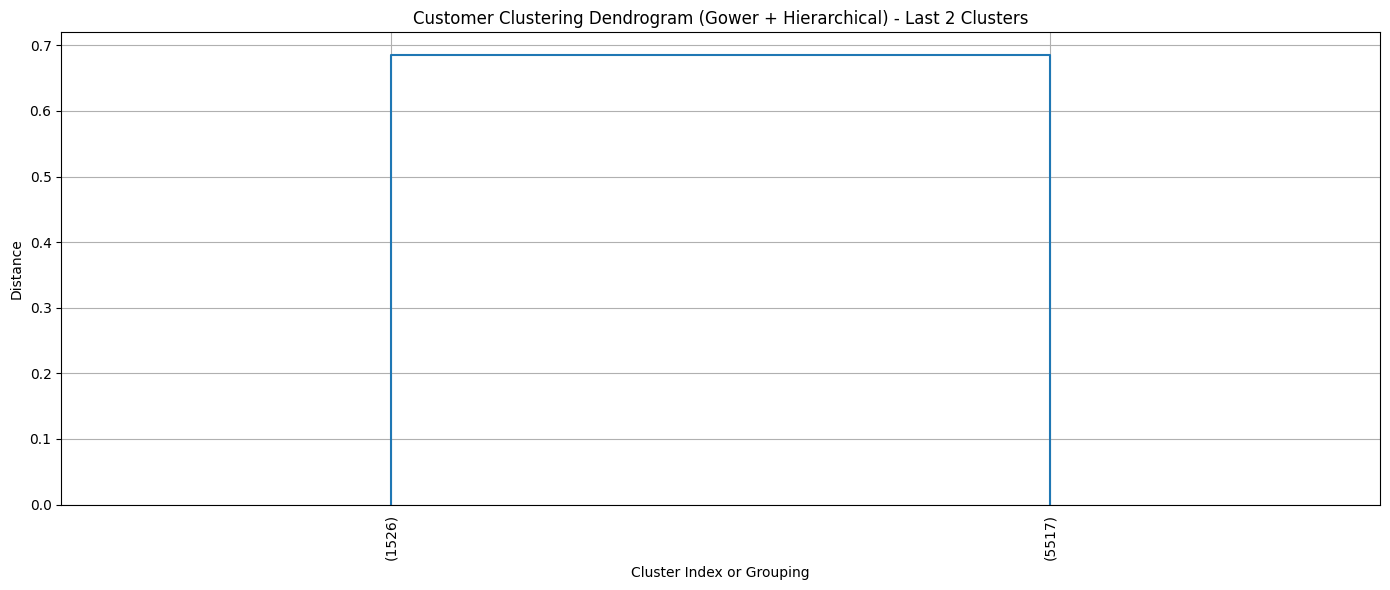

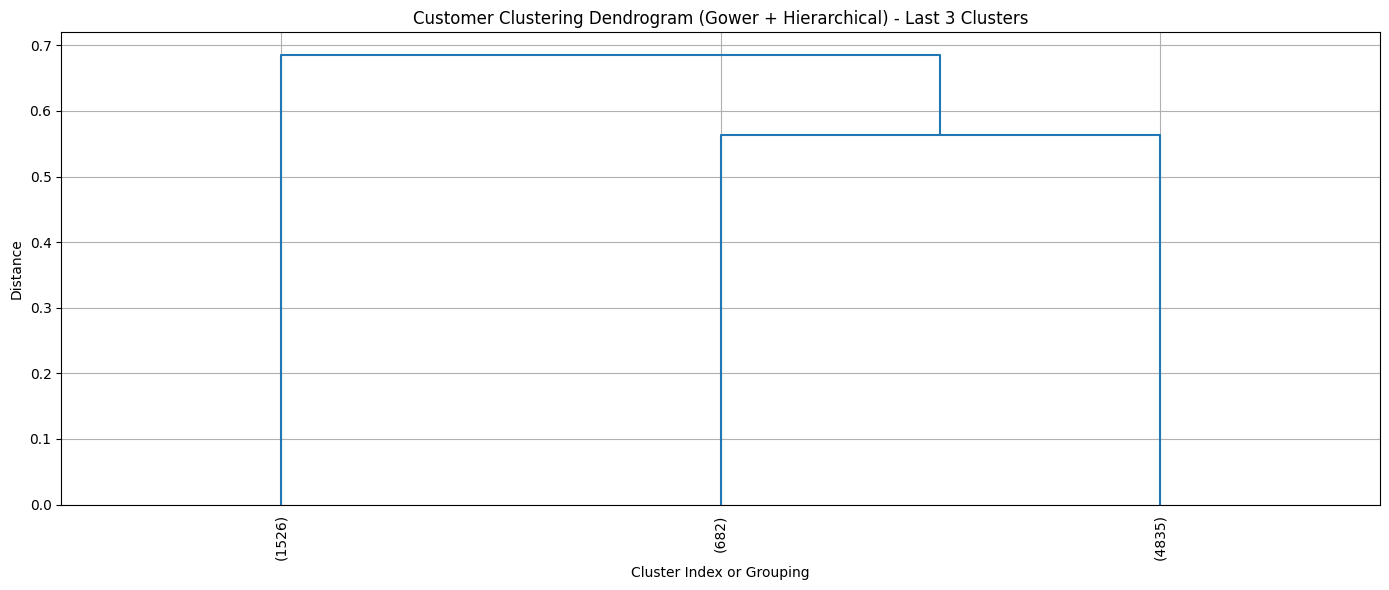

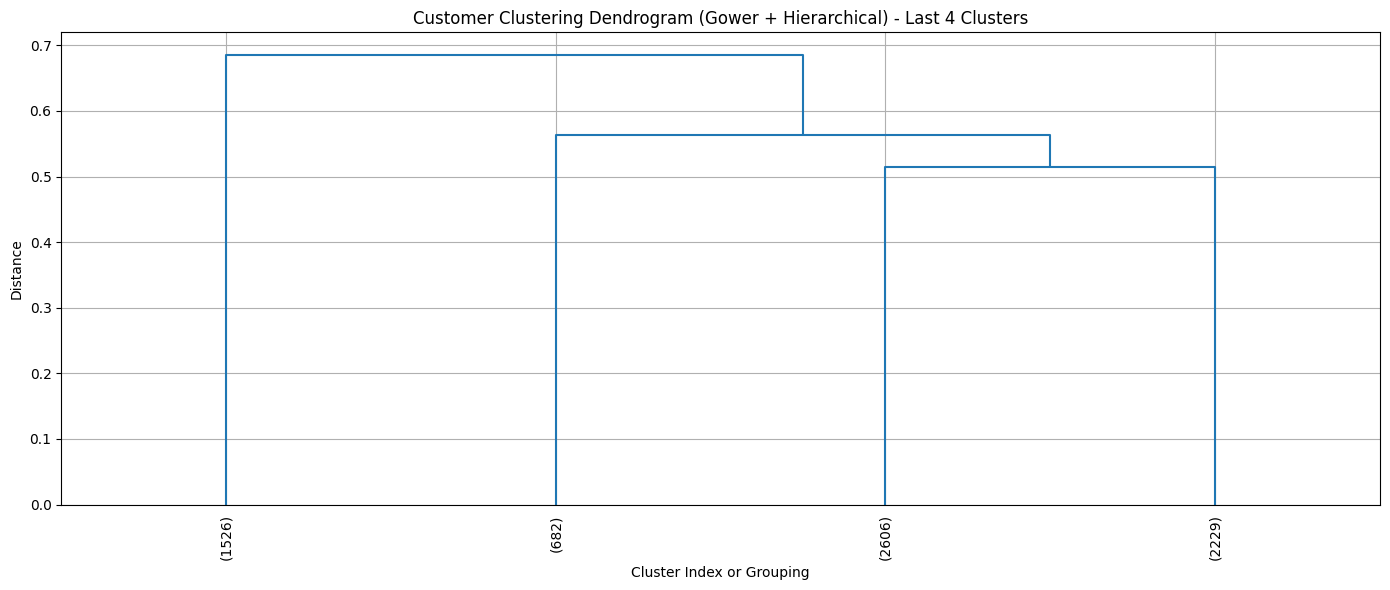

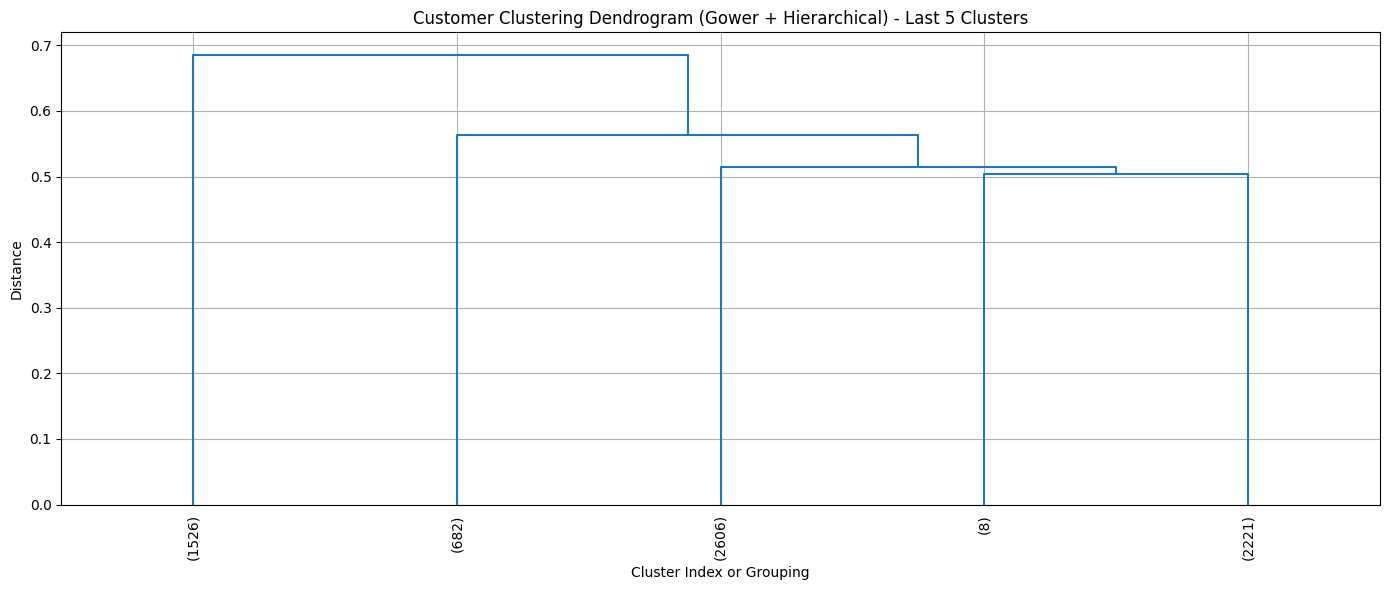

In [3]:
for p_val in range(2, 6):
    plt.figure(figsize=(14, 6))
    dendro = sch.dendrogram(linkage_matrix, 
                            truncate_mode='lastp', 
                            p=p_val, 
                            leaf_rotation=90, 
                            leaf_font_size=10)
    plt.title(f"Customer Clustering Dendrogram (Gower + Hierarchical) - Last {p_val} Clusters")
    plt.xlabel("Cluster Index or Grouping")
    plt.ylabel("Distance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [6]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'Cluster'],
      dtype='object')

### 2 Clusters

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.

📊 Numerical Feature Plots
----------------------------------------


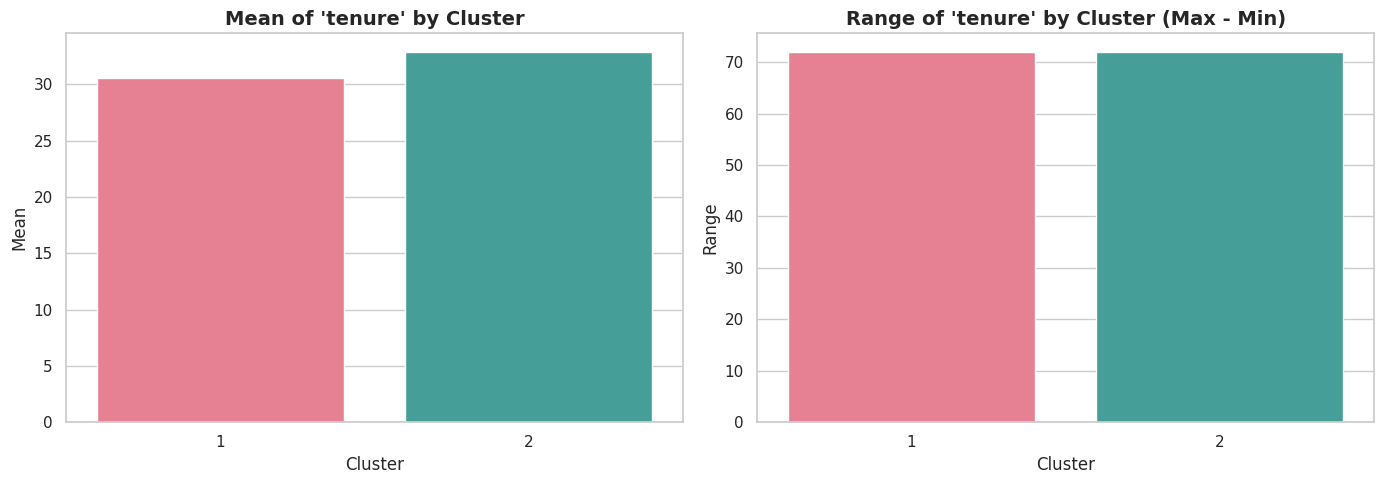

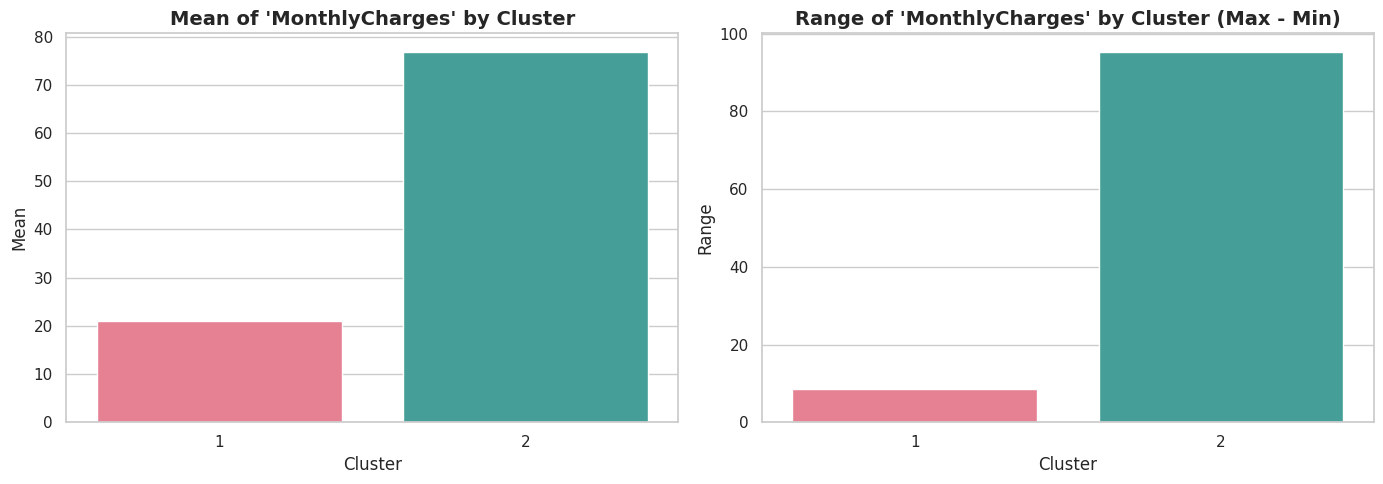

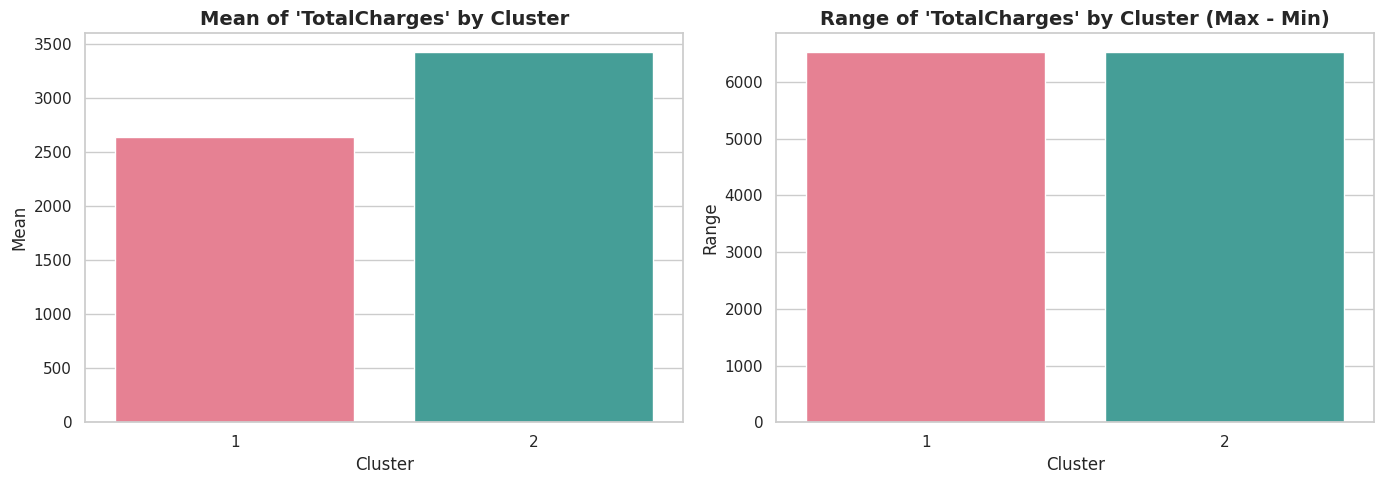


📊 Categorical Feature Plots (Percent Yes)
----------------------------------------


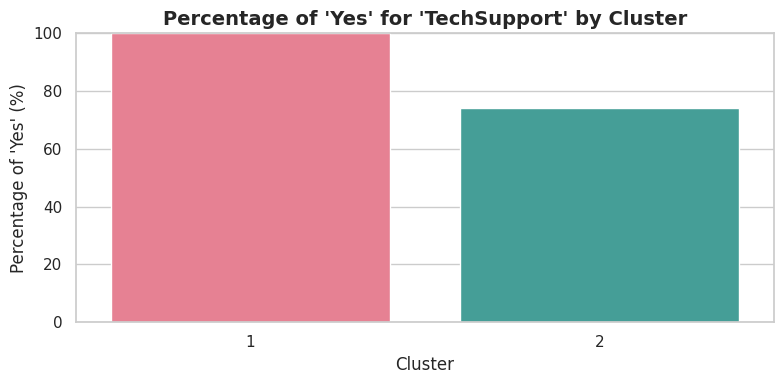

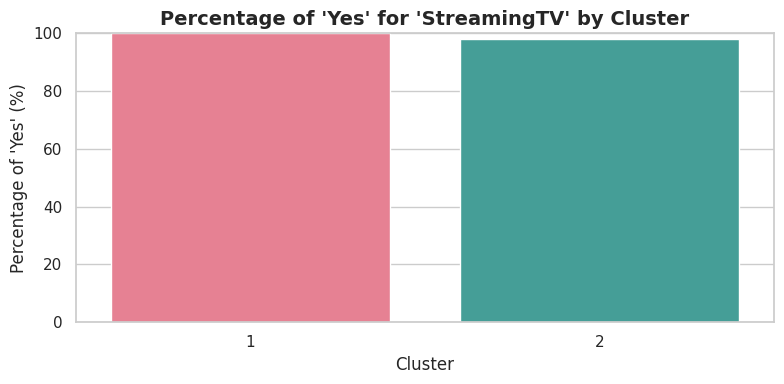

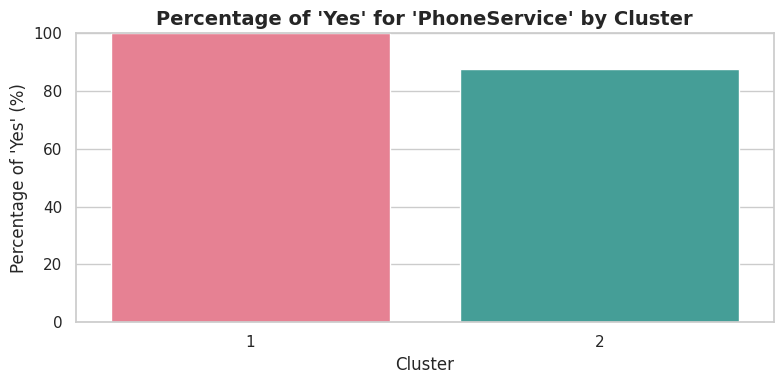

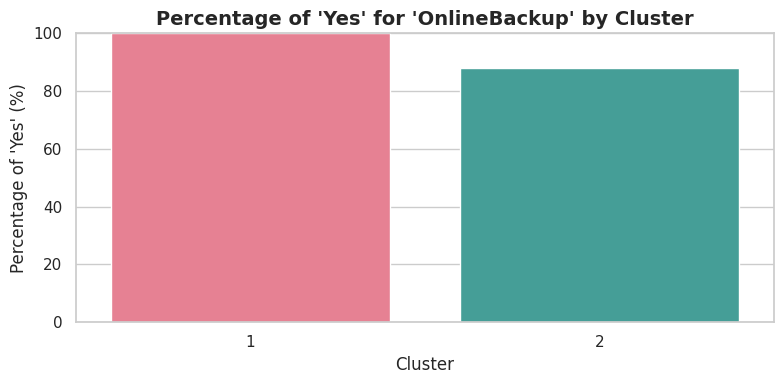

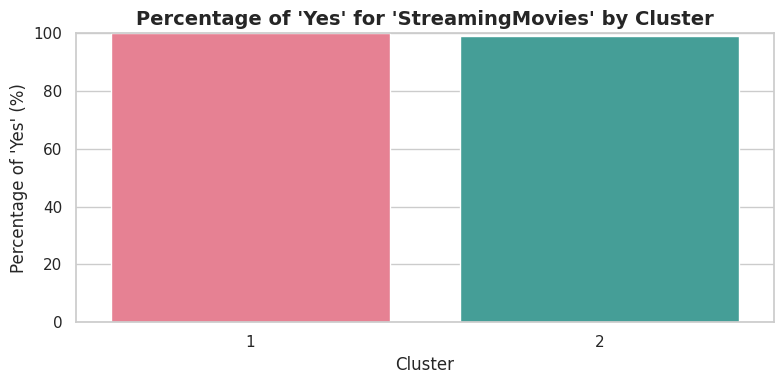

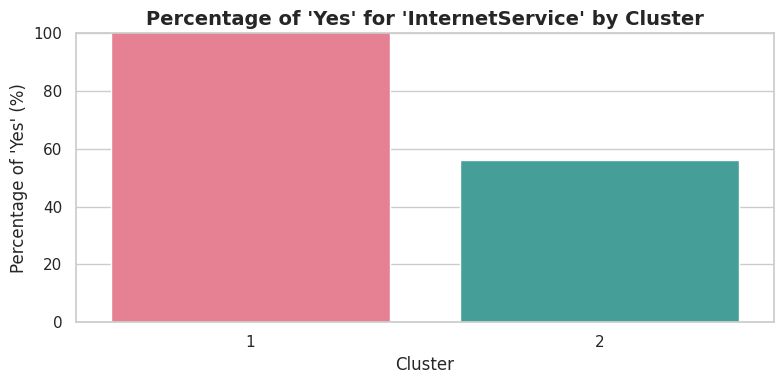

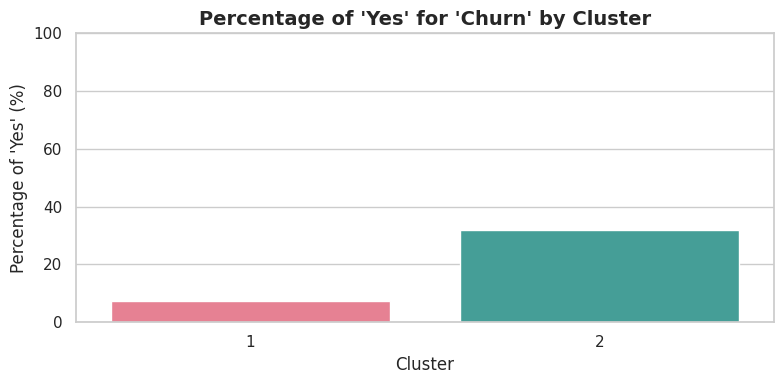

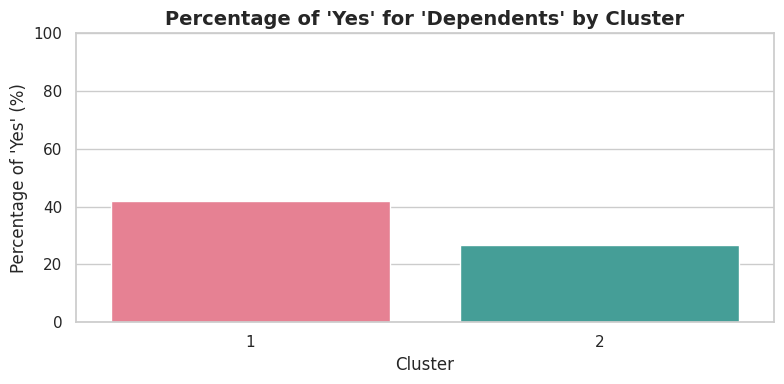

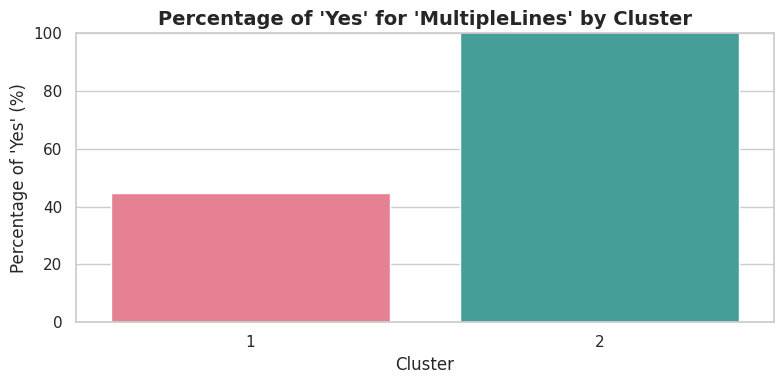

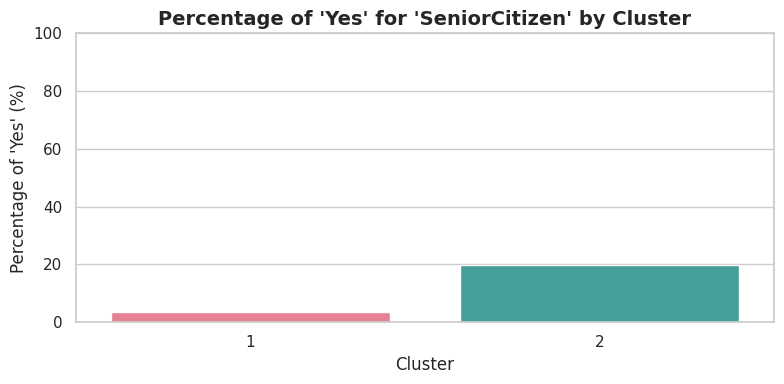

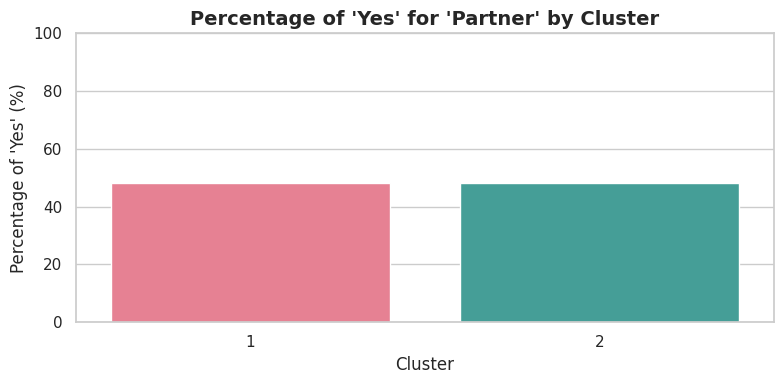

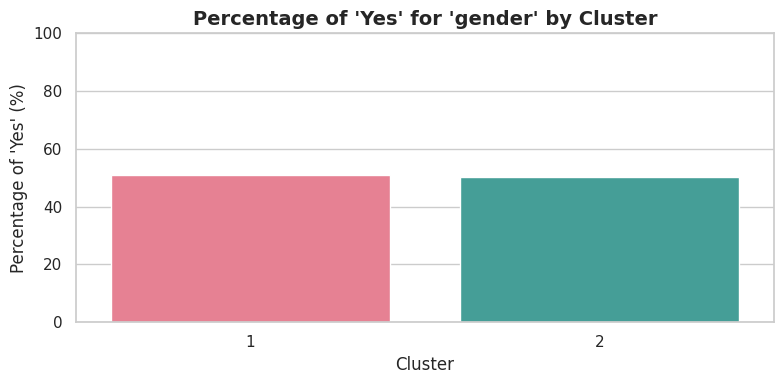

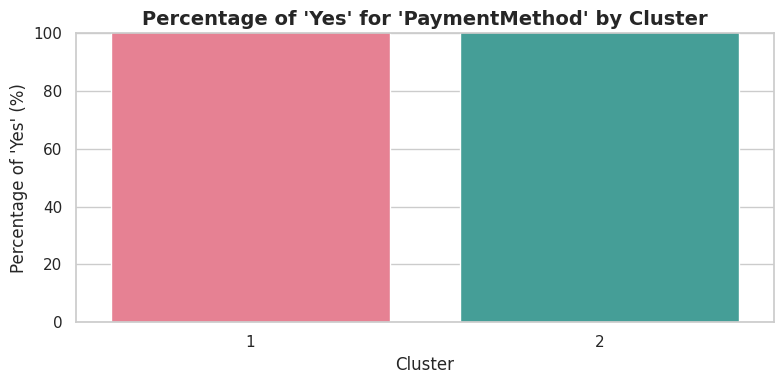

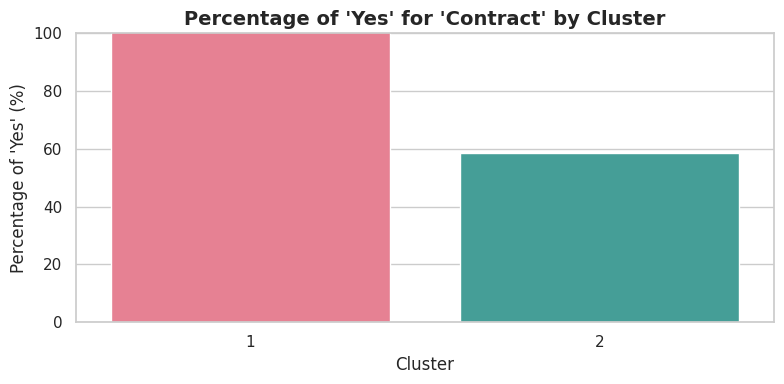

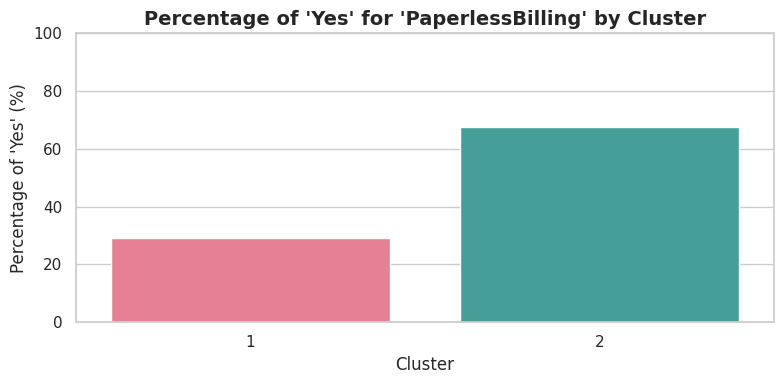

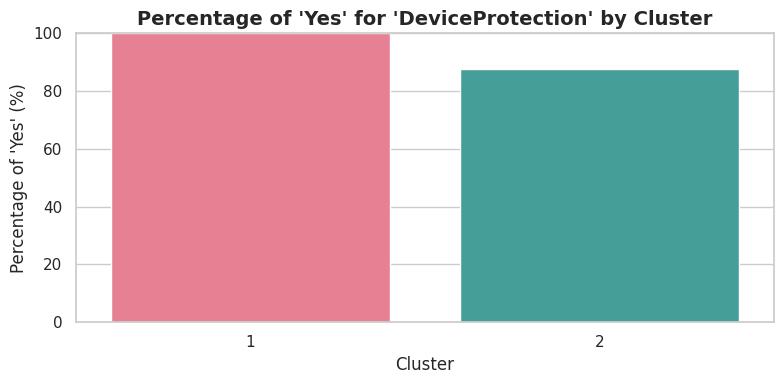

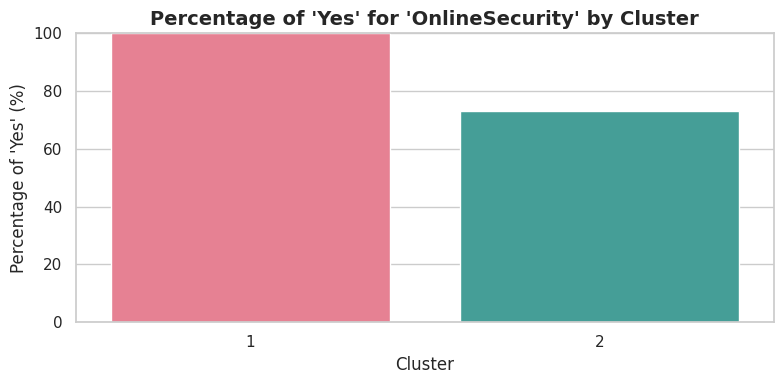

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load dataset ---
file_to_load = 'clustered_customers_k2.csv'  # Change as needed
df = pd.read_csv(file_to_load)

# --- Drop 'customerID' if present ---
if 'customerID' in df.columns:
    df.drop(columns='customerID', inplace=True)

# --- Ensure 'Cluster' is treated as categorical ---
cluster_col = 'Cluster'
df[cluster_col] = df[cluster_col].astype(str)

# --- Explicitly define numerical columns ---
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# --- All remaining columns are categorical (excluding 'Cluster') ---
all_columns = set(df.columns)
categorical_cols = list(all_columns - set(numerical_cols) - {cluster_col})

# --- Convert binary text to numeric (Yes/No to 1/0) ---
for col in categorical_cols:
    if set(df[col].dropna().unique()) <= {'Yes', 'No'}:
        df[col] = df[col].map({'Yes': 1, 'No': 0})
    elif set(df[col].dropna().unique()) <= {'True', 'False'}:
        df[col] = df[col].map({'True': 1, 'False': 0})

# --- Set up visual theme ---
sns.set(style="whitegrid")
palette = sns.color_palette("husl", df[cluster_col].nunique())  # Distinct cluster colors
title_font = {'fontsize': 14, 'fontweight': 'bold'}

# ==========================================
# NUMERICAL FEATURE ANALYSIS
# ==========================================
print("\n📊 Numerical Feature Plots\n" + "-" * 40)
for col in numerical_cols:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Summary stats
    summary_df = df.groupby(cluster_col)[col].agg(['mean', 'min', 'max']).reset_index()
    summary_df['range'] = summary_df['max'] - summary_df['min']

    # Mean plot
    sns.barplot(data=summary_df, x=cluster_col, y='mean', palette=palette, ax=axs[0])
    axs[0].set_title(f"Mean of '{col}' by Cluster", **title_font)
    axs[0].set_xlabel("Cluster")
    axs[0].set_ylabel("Mean")

    # Range plot
    sns.barplot(data=summary_df, x=cluster_col, y='range', palette=palette, ax=axs[1])
    axs[1].set_title(f"Range of '{col}' by Cluster (Max - Min)", **title_font)
    axs[1].set_xlabel("Cluster")
    axs[1].set_ylabel("Range")

    plt.tight_layout()
    plt.show()

# ==========================================
# CATEGORICAL FEATURE ANALYSIS
# ==========================================
print("\n📊 Categorical Feature Plots (Percent Yes)\n" + "-" * 40)
for col in categorical_cols:
    plt.figure(figsize=(8, 4))

    # Compute percentage of 1s per cluster
    percent_df = df.groupby(cluster_col)[col].mean().reset_index()
    percent_df[col] = percent_df[col] * 100  # convert to percentage

    sns.barplot(data=percent_df, x=cluster_col, y=col, palette=palette)
    plt.title(f"Percentage of 'Yes' for '{col}' by Cluster", **title_font)
    plt.ylabel("Percentage of 'Yes' (%)")
    plt.xlabel("Cluster")
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


### 3 Clusters


📊 Numerical Feature Plots
----------------------------------------


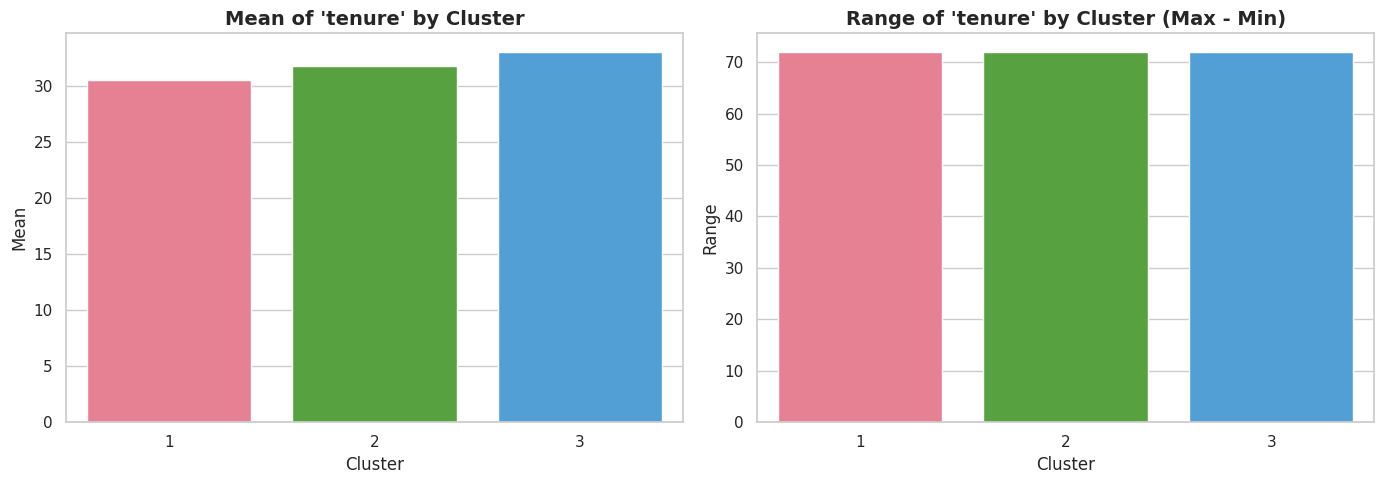

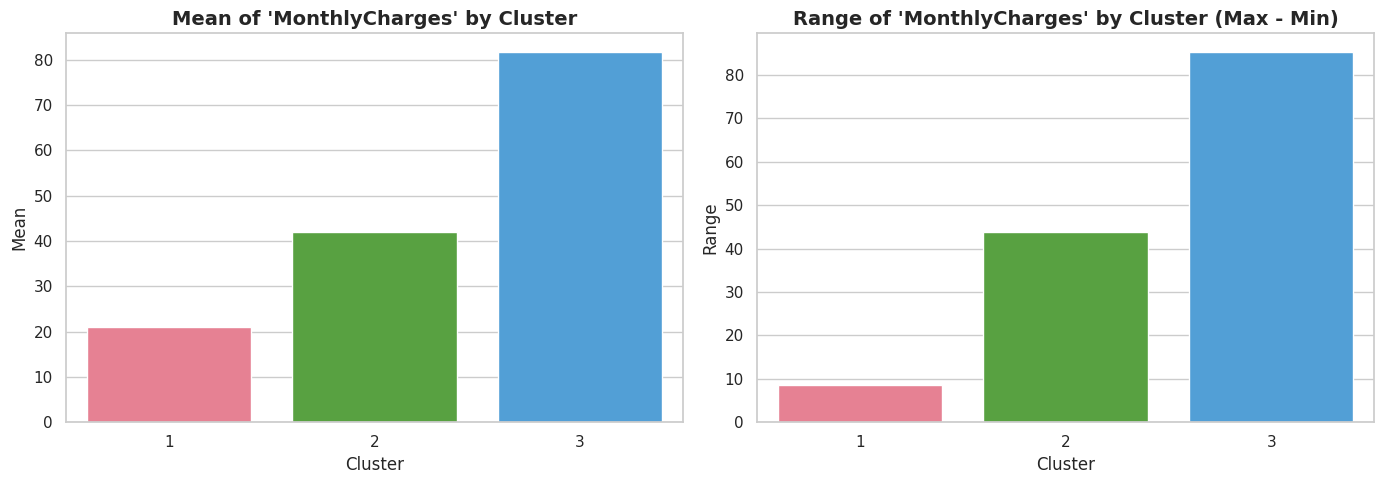

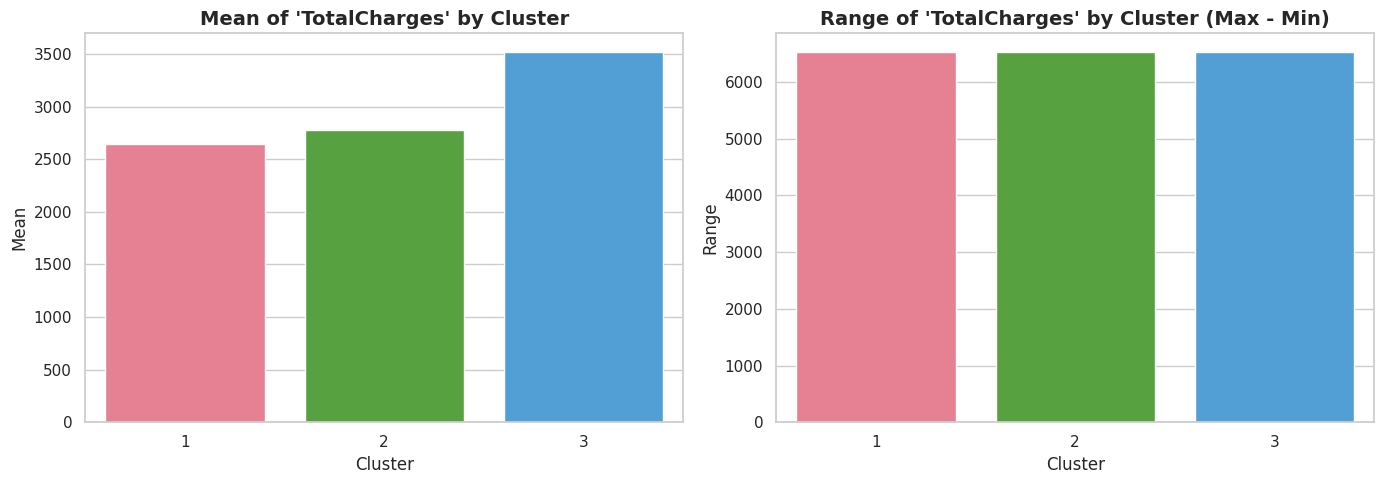


📊 Categorical Feature Plots (Percent Yes)
----------------------------------------


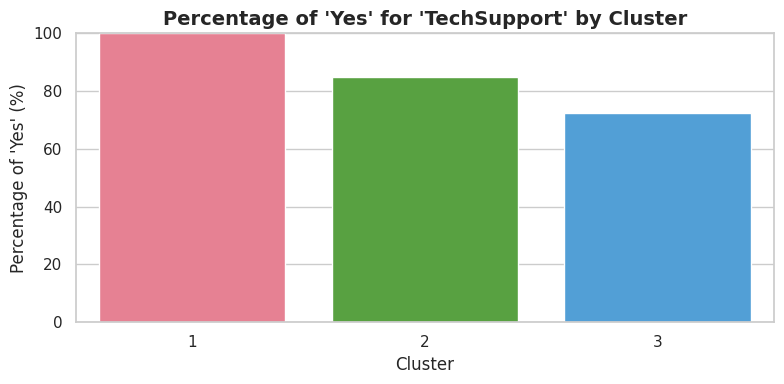

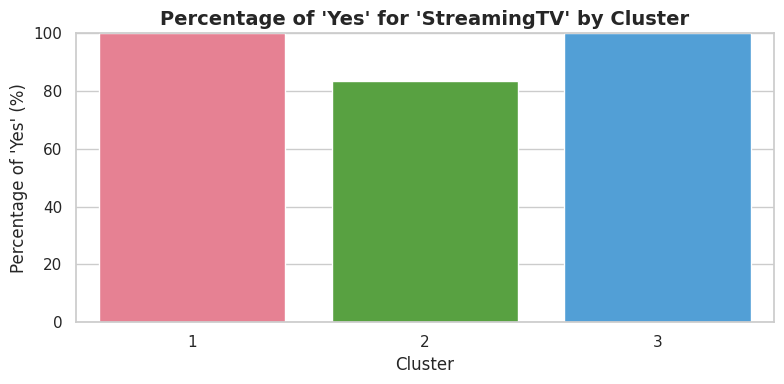

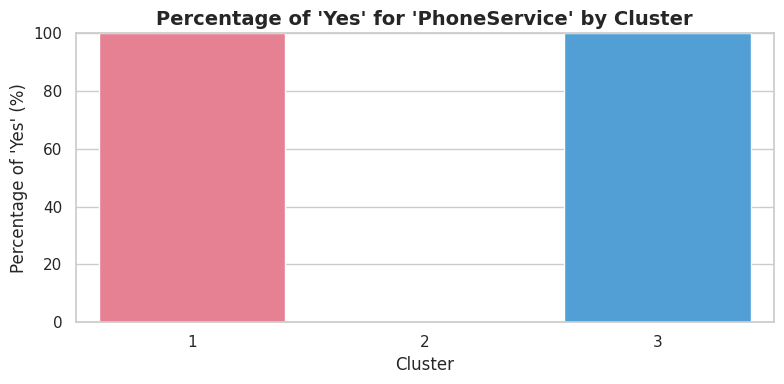

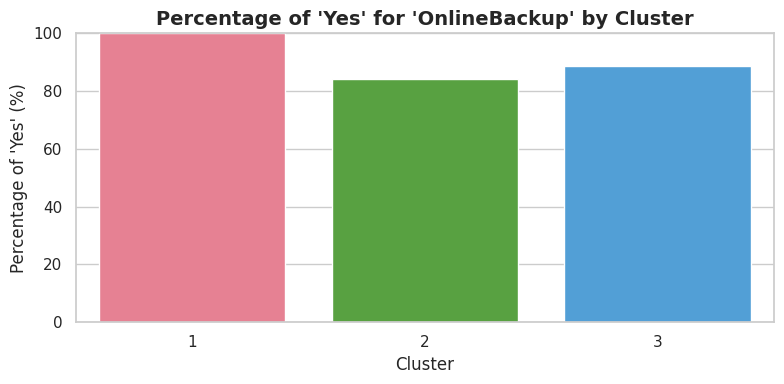

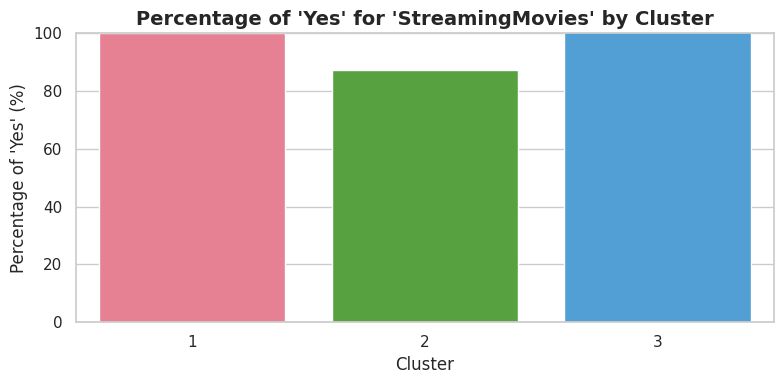

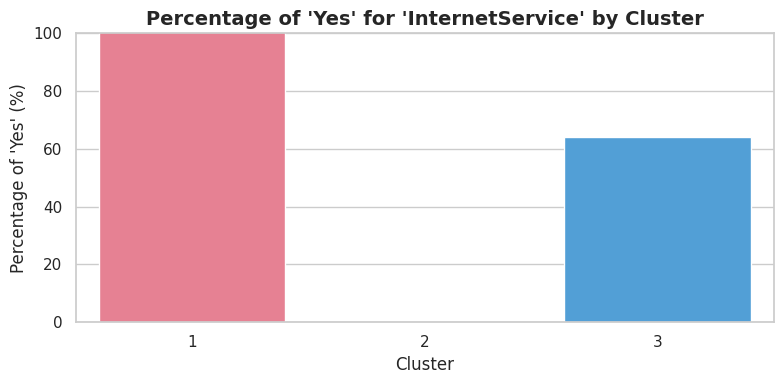

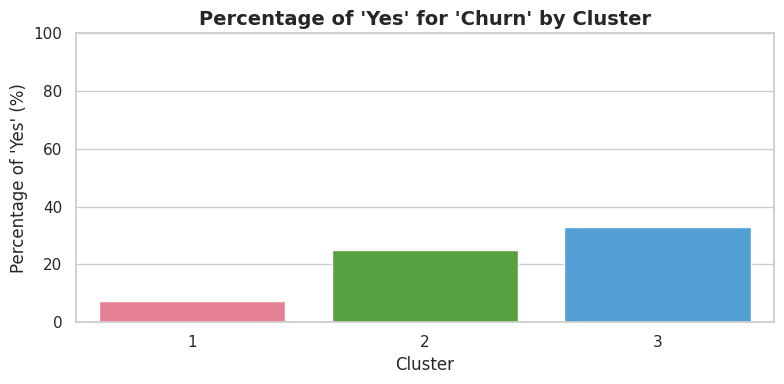

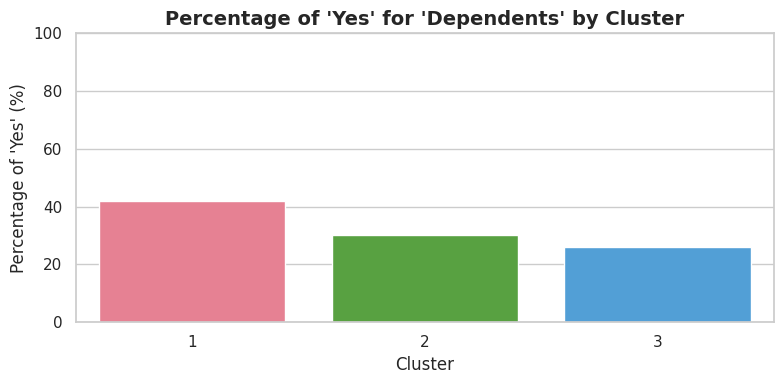

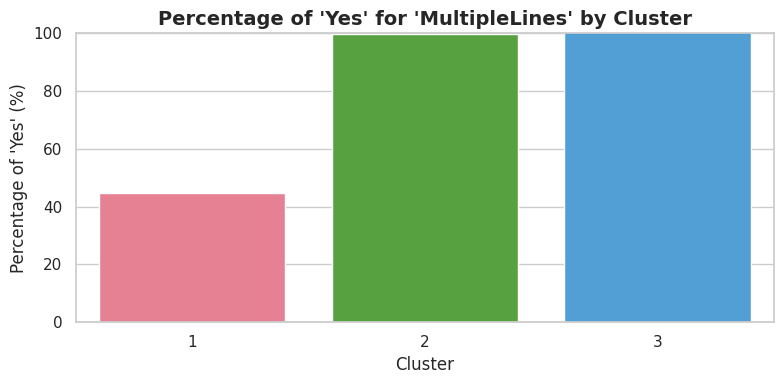

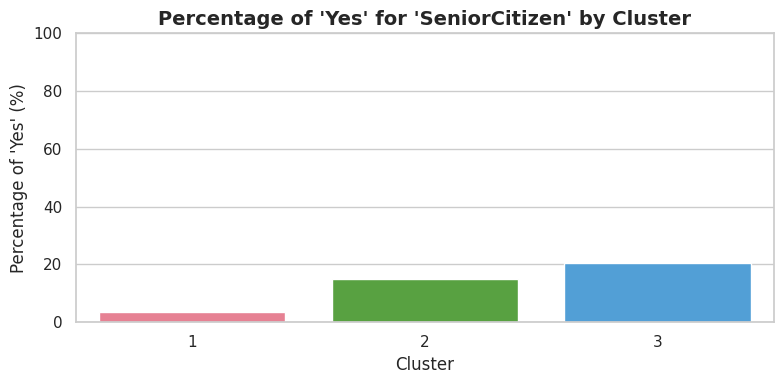

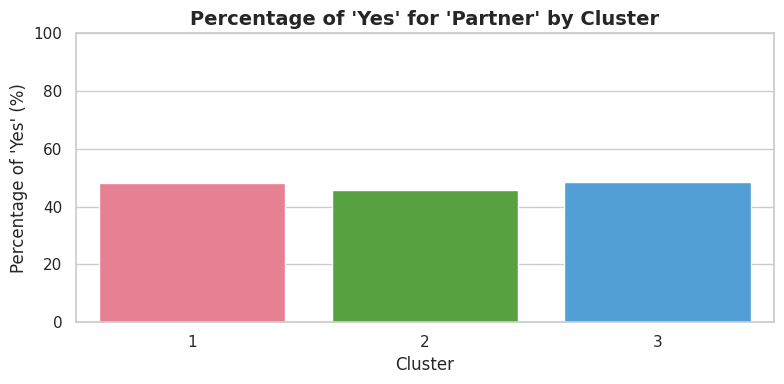

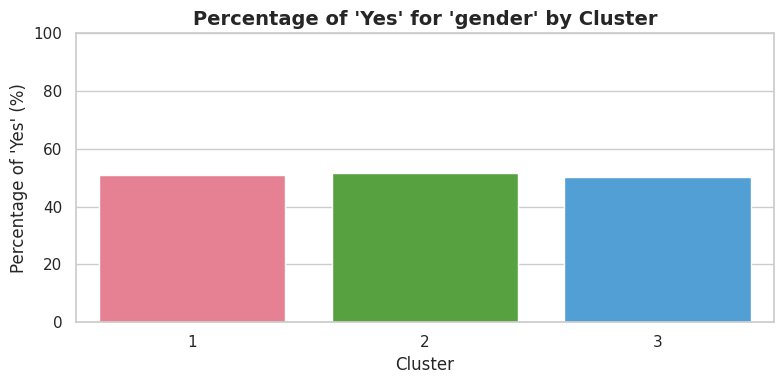

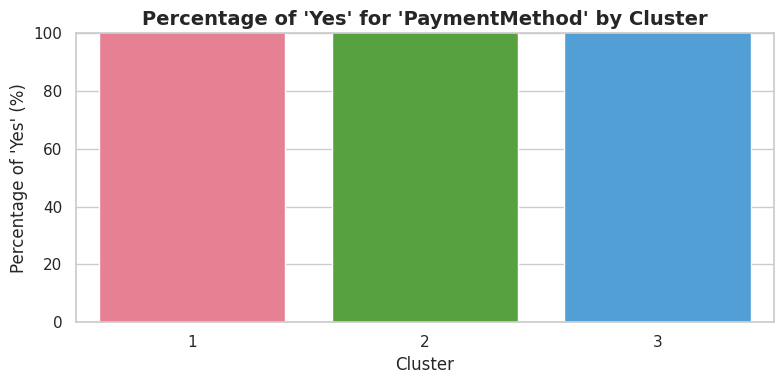

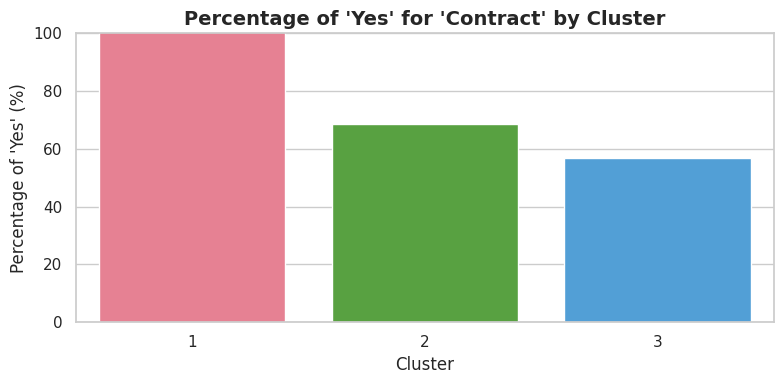

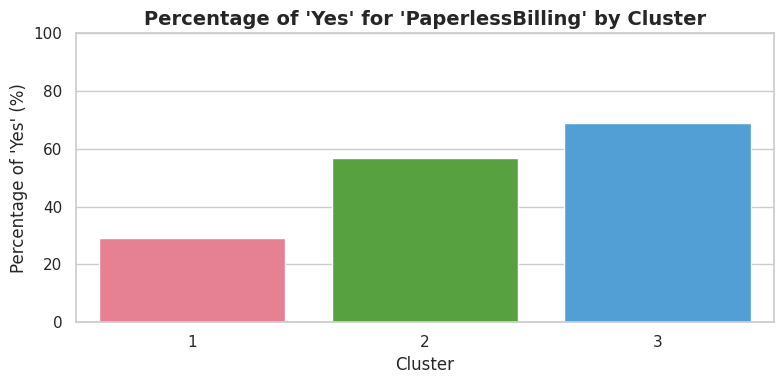

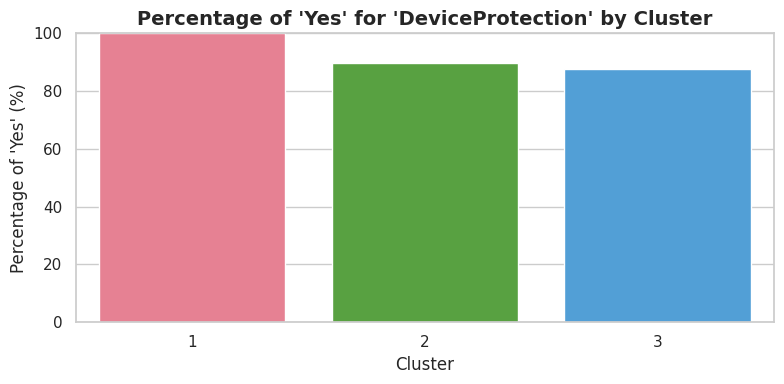

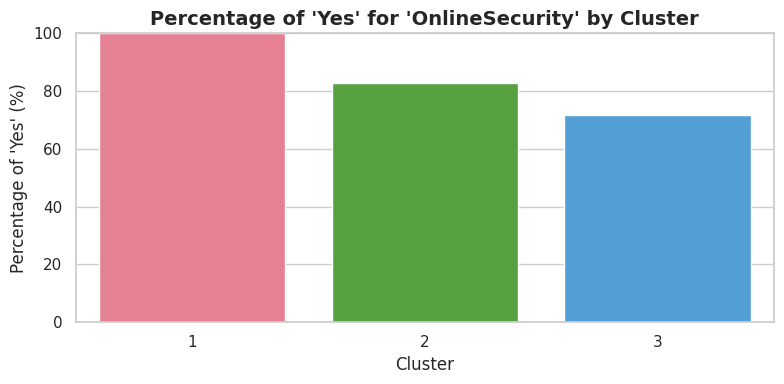

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load dataset ---
file_to_load = 'clustered_customers_k3.csv'  # Change as needed
df = pd.read_csv(file_to_load)

# --- Drop 'customerID' if present ---
if 'customerID' in df.columns:
    df.drop(columns='customerID', inplace=True)

# --- Ensure 'Cluster' is treated as categorical ---
cluster_col = 'Cluster'
df[cluster_col] = df[cluster_col].astype(str)

# --- Explicitly define numerical columns ---
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# --- All remaining columns are categorical (excluding 'Cluster') ---
all_columns = set(df.columns)
categorical_cols = list(all_columns - set(numerical_cols) - {cluster_col})

# --- Convert binary text to numeric (Yes/No to 1/0) ---
for col in categorical_cols:
    if set(df[col].dropna().unique()) <= {'Yes', 'No'}:
        df[col] = df[col].map({'Yes': 1, 'No': 0})
    elif set(df[col].dropna().unique()) <= {'True', 'False'}:
        df[col] = df[col].map({'True': 1, 'False': 0})

# --- Set up visual theme ---
sns.set(style="whitegrid")
palette = sns.color_palette("husl", df[cluster_col].nunique())  # Distinct cluster colors
title_font = {'fontsize': 14, 'fontweight': 'bold'}

# ==========================================
# NUMERICAL FEATURE ANALYSIS
# ==========================================
print("\n📊 Numerical Feature Plots\n" + "-" * 40)
for col in numerical_cols:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Summary stats
    summary_df = df.groupby(cluster_col)[col].agg(['mean', 'min', 'max']).reset_index()
    summary_df['range'] = summary_df['max'] - summary_df['min']

    # Mean plot
    sns.barplot(data=summary_df, x=cluster_col, y='mean', palette=palette, ax=axs[0])
    axs[0].set_title(f"Mean of '{col}' by Cluster", **title_font)
    axs[0].set_xlabel("Cluster")
    axs[0].set_ylabel("Mean")

    # Range plot
    sns.barplot(data=summary_df, x=cluster_col, y='range', palette=palette, ax=axs[1])
    axs[1].set_title(f"Range of '{col}' by Cluster (Max - Min)", **title_font)
    axs[1].set_xlabel("Cluster")
    axs[1].set_ylabel("Range")

    plt.tight_layout()
    plt.show()

# ==========================================
# CATEGORICAL FEATURE ANALYSIS
# ==========================================
print("\n📊 Categorical Feature Plots (Percent Yes)\n" + "-" * 40)
for col in categorical_cols:
    plt.figure(figsize=(8, 4))

    # Compute percentage of 1s per cluster
    percent_df = df.groupby(cluster_col)[col].mean().reset_index()
    percent_df[col] = percent_df[col] * 100  # convert to percentage

    sns.barplot(data=percent_df, x=cluster_col, y=col, palette=palette)
    plt.title(f"Percentage of 'Yes' for '{col}' by Cluster", **title_font)
    plt.ylabel("Percentage of 'Yes' (%)")
    plt.xlabel("Cluster")
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


### 4 Clusters


📊 Numerical Feature Plots
----------------------------------------


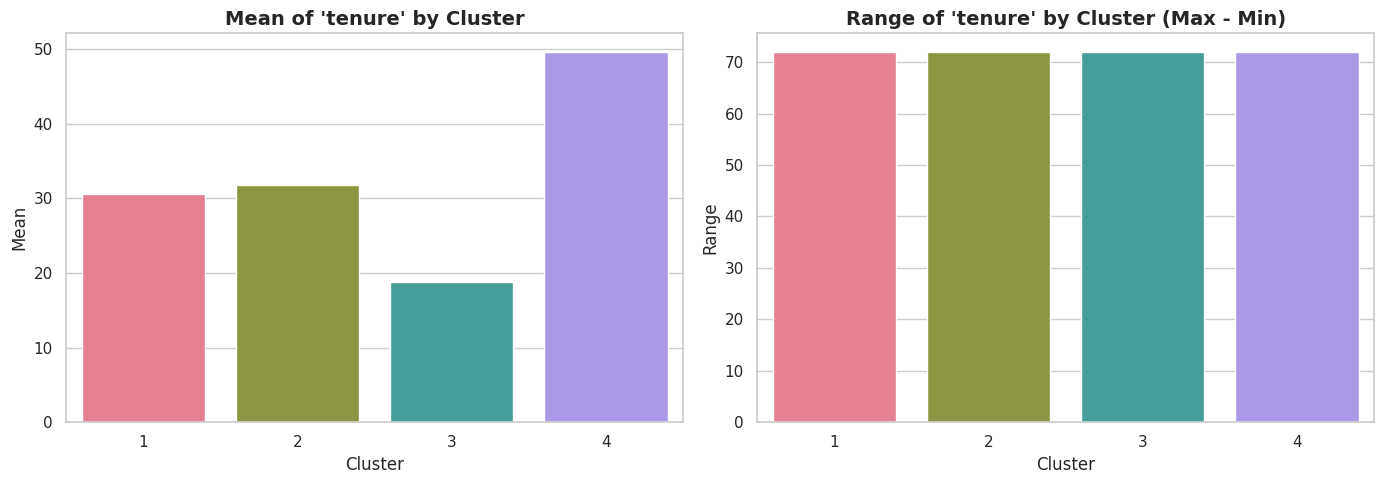

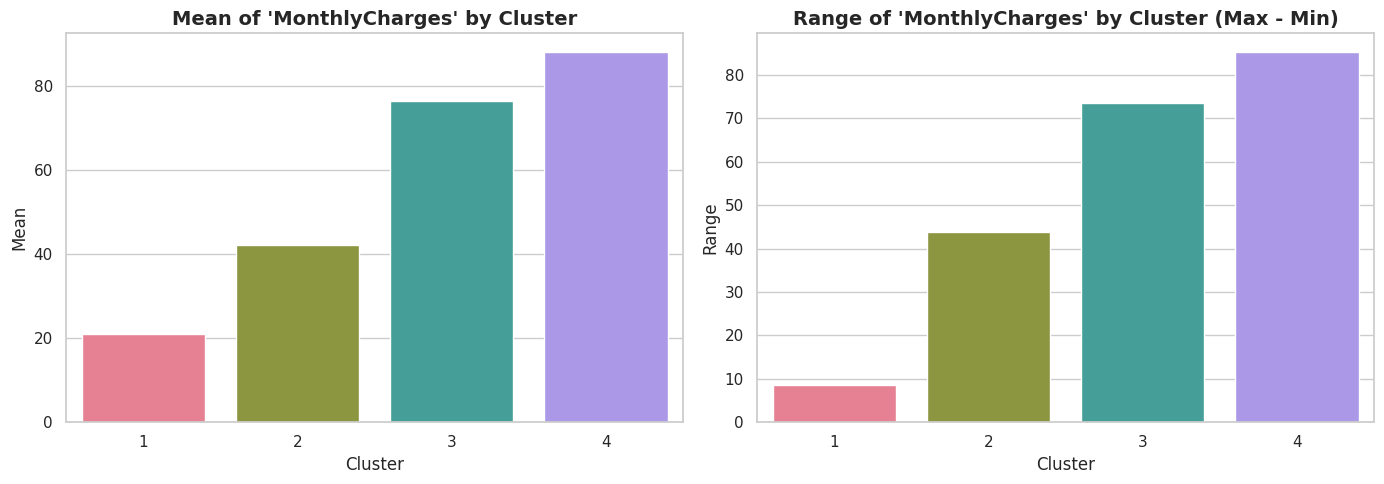

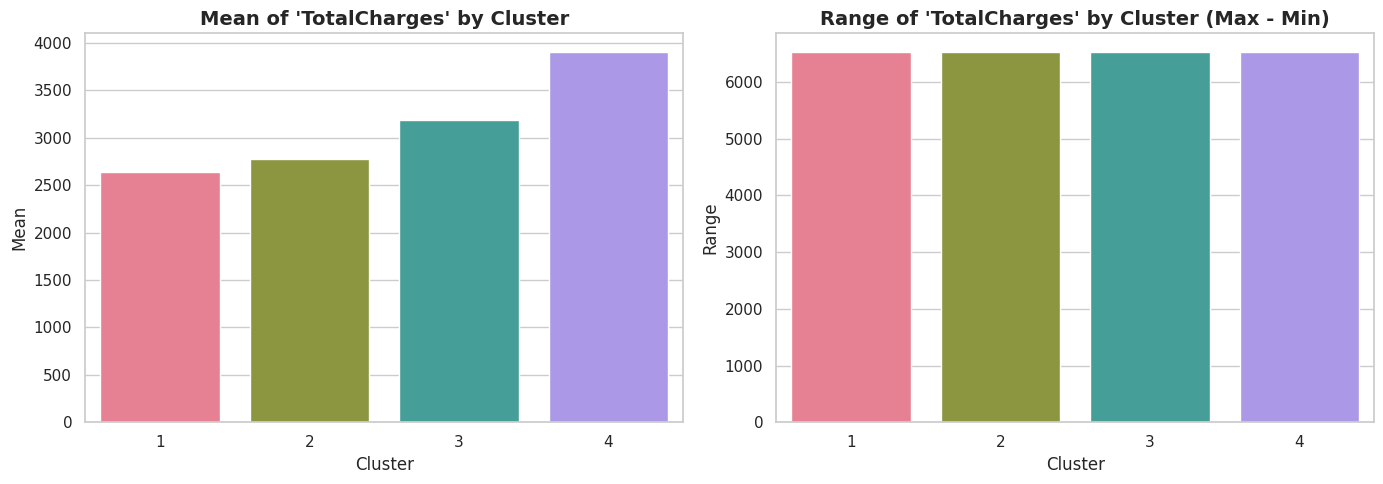


📊 Categorical Feature Plots (Percent Yes)
----------------------------------------


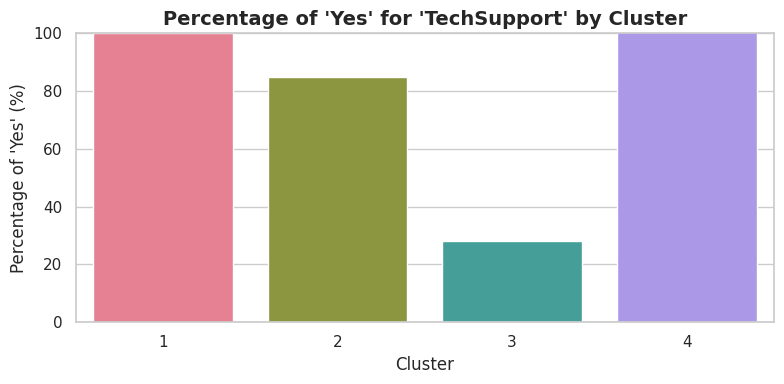

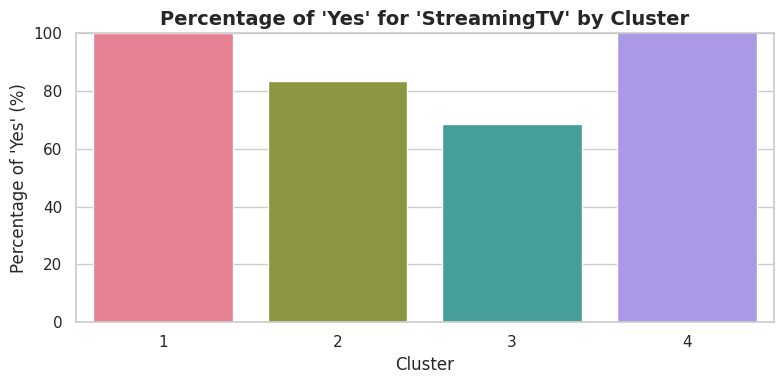

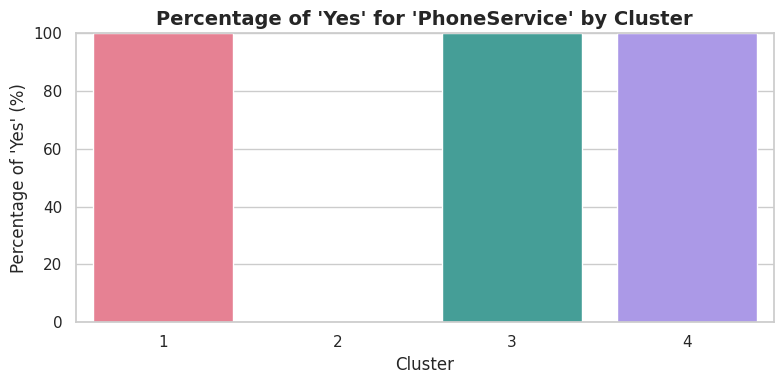

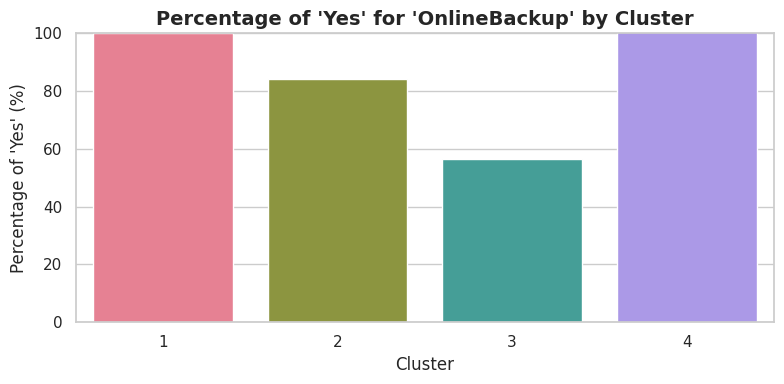

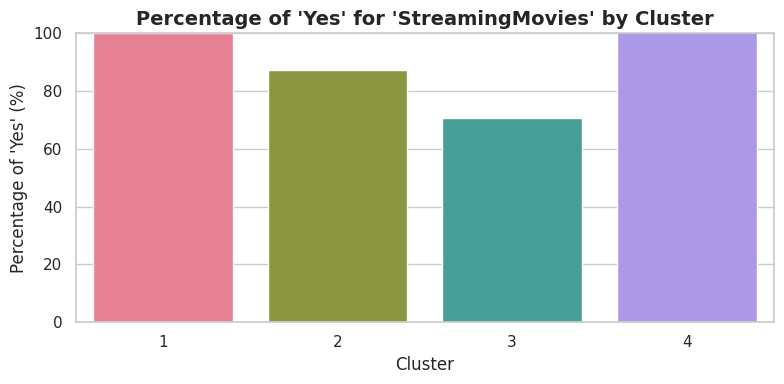

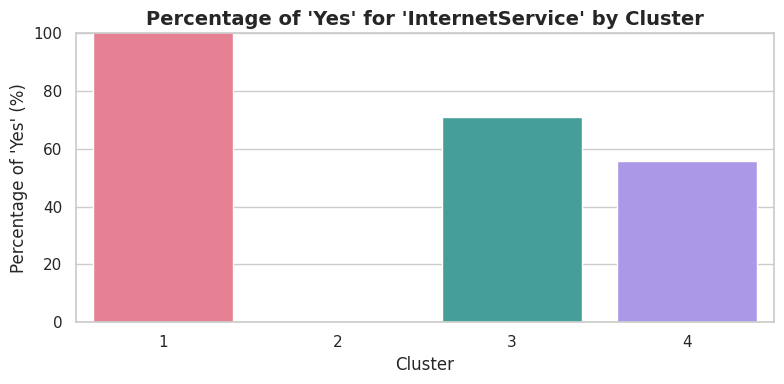

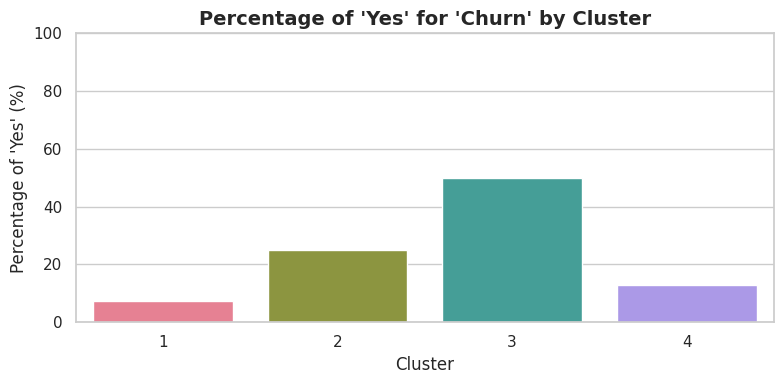

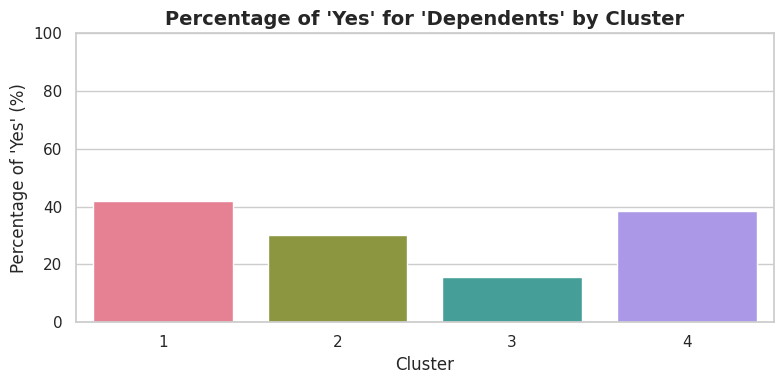

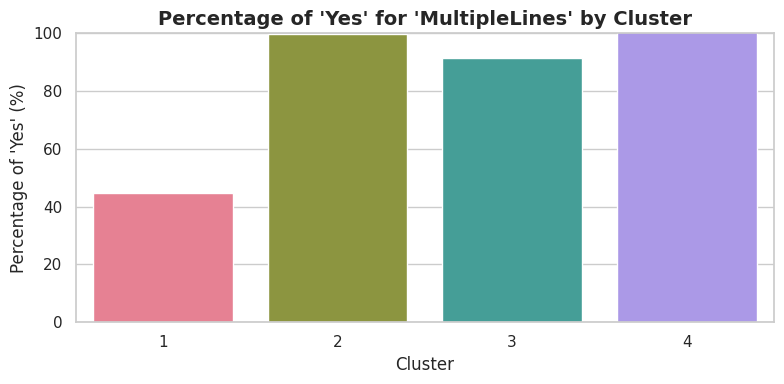

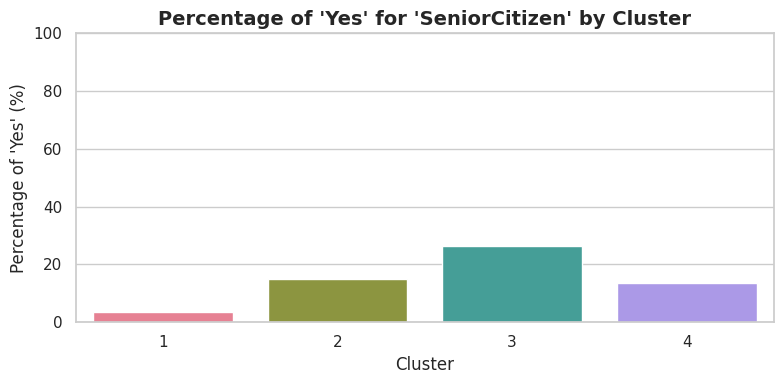

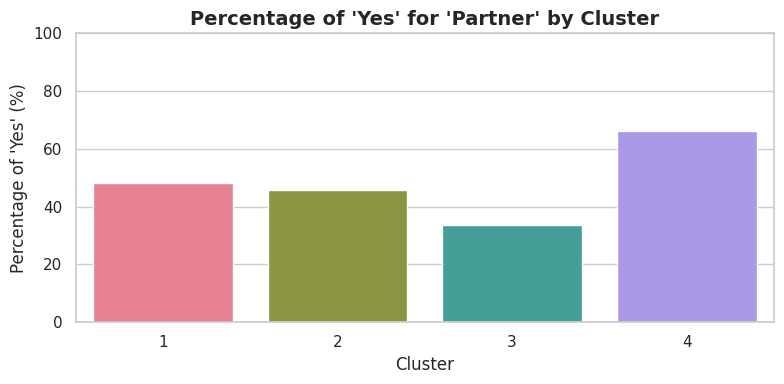

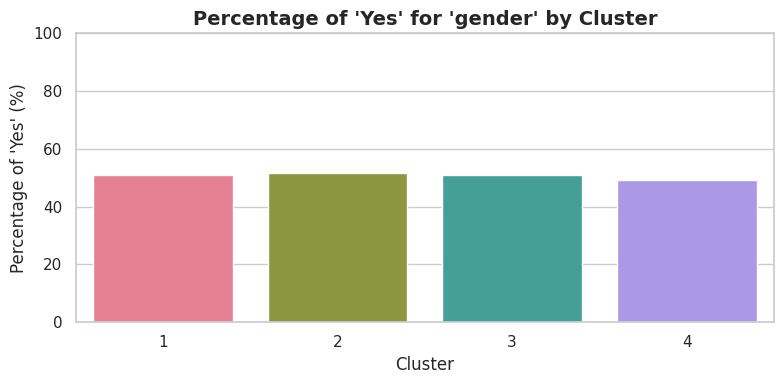

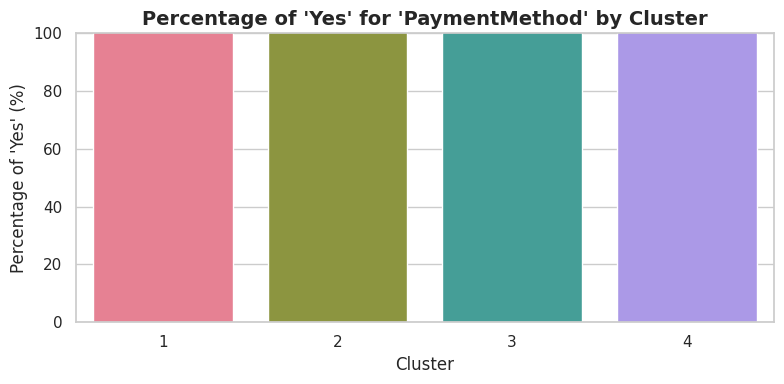

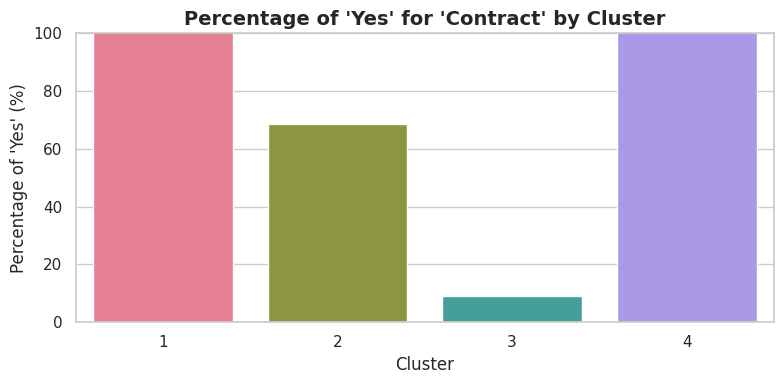

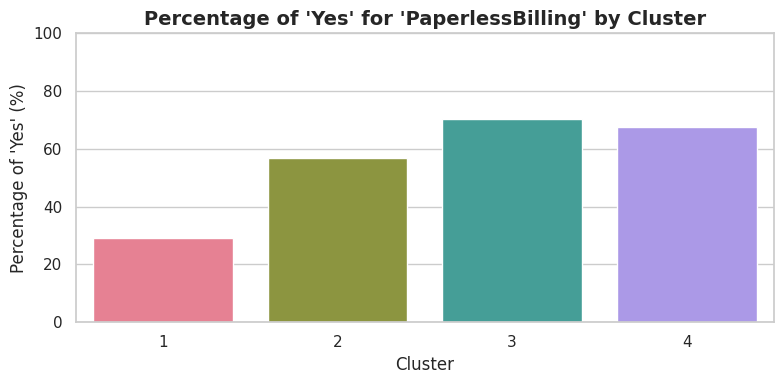

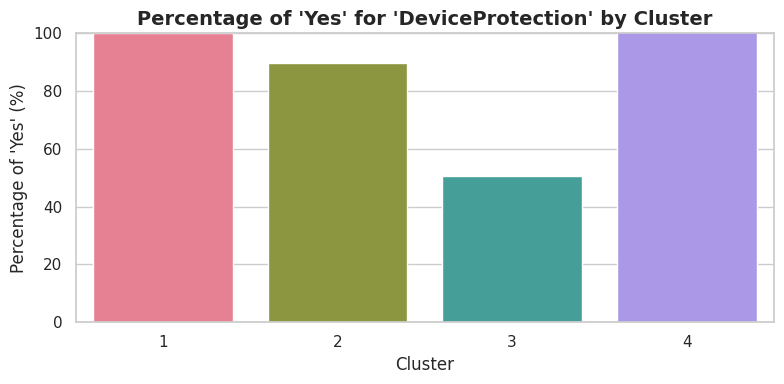

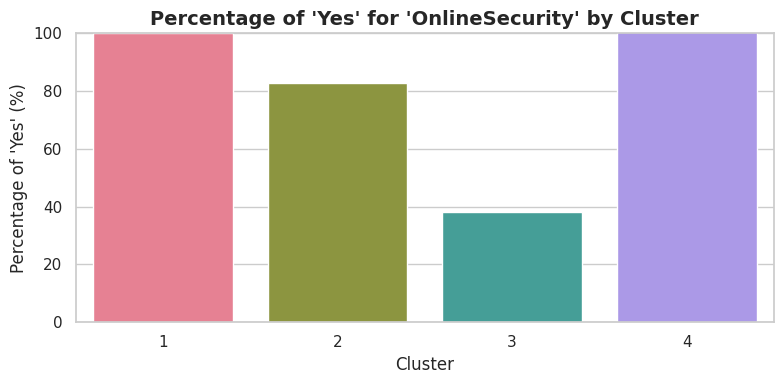

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load dataset ---
file_to_load = 'clustered_customers_k4.csv'  # Change as needed
df = pd.read_csv(file_to_load)

# --- Drop 'customerID' if present ---
if 'customerID' in df.columns:
    df.drop(columns='customerID', inplace=True)

# --- Ensure 'Cluster' is treated as categorical ---
cluster_col = 'Cluster'
df[cluster_col] = df[cluster_col].astype(str)

# --- Explicitly define numerical columns ---
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# --- All remaining columns are categorical (excluding 'Cluster') ---
all_columns = set(df.columns)
categorical_cols = list(all_columns - set(numerical_cols) - {cluster_col})

# --- Convert binary text to numeric (Yes/No to 1/0) ---
for col in categorical_cols:
    if set(df[col].dropna().unique()) <= {'Yes', 'No'}:
        df[col] = df[col].map({'Yes': 1, 'No': 0})
    elif set(df[col].dropna().unique()) <= {'True', 'False'}:
        df[col] = df[col].map({'True': 1, 'False': 0})

# --- Set up visual theme ---
sns.set(style="whitegrid")
palette = sns.color_palette("husl", df[cluster_col].nunique())  # Distinct cluster colors
title_font = {'fontsize': 14, 'fontweight': 'bold'}

# ==========================================
# NUMERICAL FEATURE ANALYSIS
# ==========================================
print("\n📊 Numerical Feature Plots\n" + "-" * 40)
for col in numerical_cols:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Summary stats
    summary_df = df.groupby(cluster_col)[col].agg(['mean', 'min', 'max']).reset_index()
    summary_df['range'] = summary_df['max'] - summary_df['min']

    # Mean plot
    sns.barplot(data=summary_df, x=cluster_col, y='mean', palette=palette, ax=axs[0])
    axs[0].set_title(f"Mean of '{col}' by Cluster", **title_font)
    axs[0].set_xlabel("Cluster")
    axs[0].set_ylabel("Mean")

    # Range plot
    sns.barplot(data=summary_df, x=cluster_col, y='range', palette=palette, ax=axs[1])
    axs[1].set_title(f"Range of '{col}' by Cluster (Max - Min)", **title_font)
    axs[1].set_xlabel("Cluster")
    axs[1].set_ylabel("Range")

    plt.tight_layout()
    plt.show()

# ==========================================
# CATEGORICAL FEATURE ANALYSIS
# ==========================================
print("\n📊 Categorical Feature Plots (Percent Yes)\n" + "-" * 40)
for col in categorical_cols:
    plt.figure(figsize=(8, 4))

    # Compute percentage of 1s per cluster
    percent_df = df.groupby(cluster_col)[col].mean().reset_index()
    percent_df[col] = percent_df[col] * 100  # convert to percentage

    sns.barplot(data=percent_df, x=cluster_col, y=col, palette=palette)
    plt.title(f"Percentage of 'Yes' for '{col}' by Cluster", **title_font)
    plt.ylabel("Percentage of 'Yes' (%)")
    plt.xlabel("Cluster")
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


### 5 Clusters


📊 Numerical Feature Plots
----------------------------------------


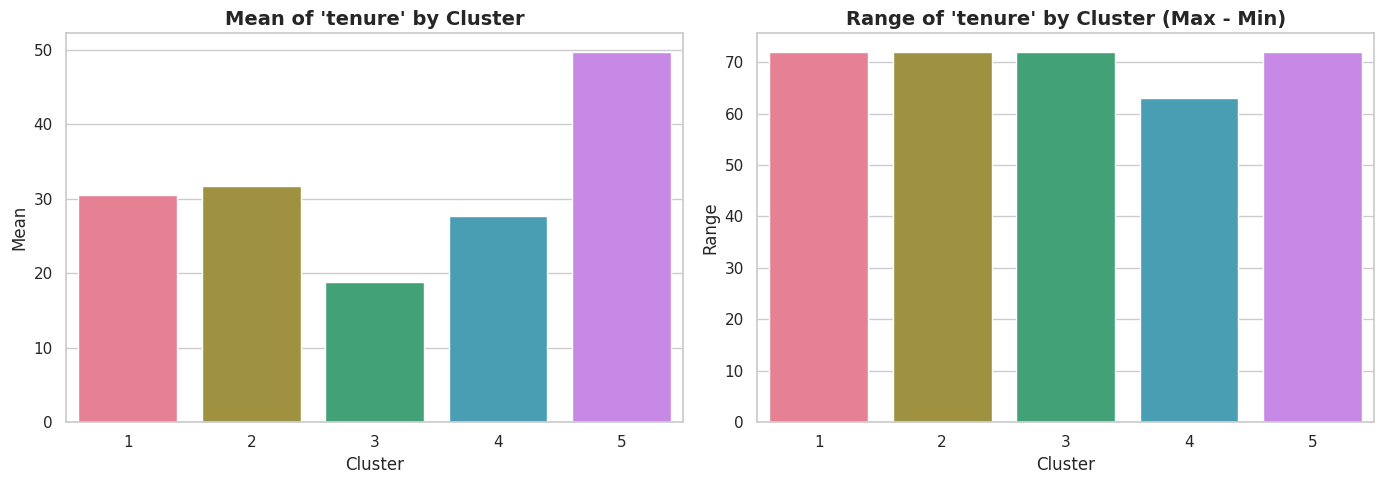

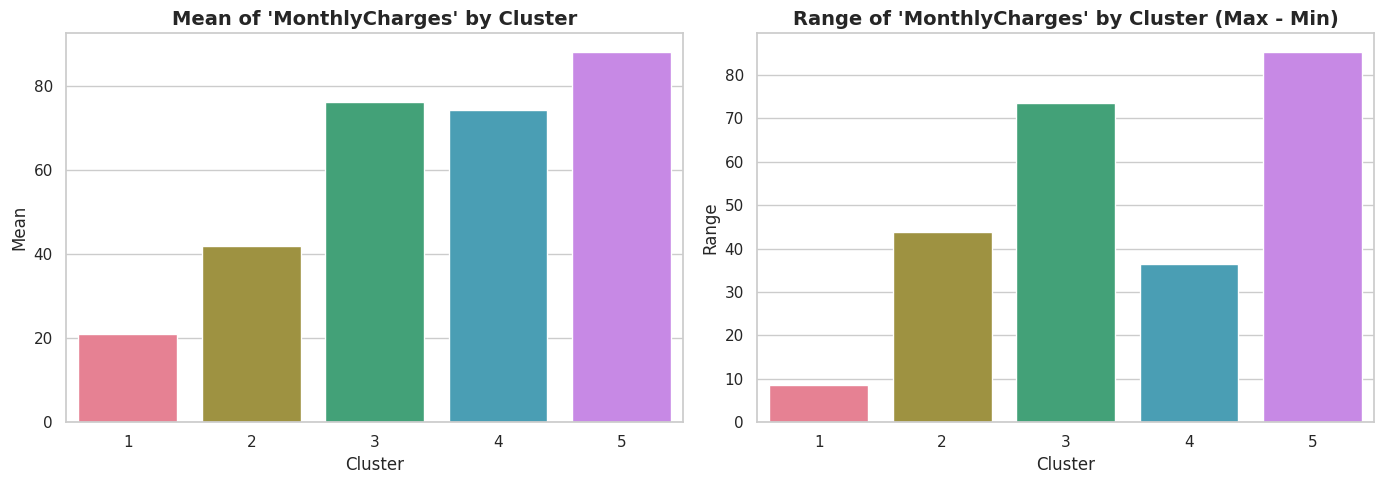

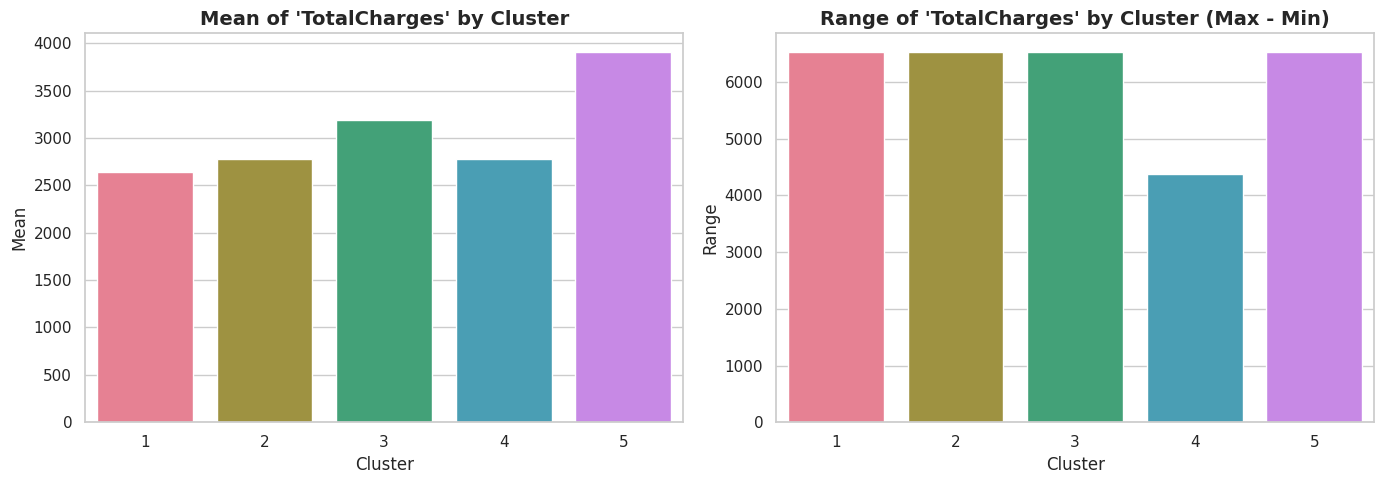


📊 Categorical Feature Plots (Percent Yes)
----------------------------------------


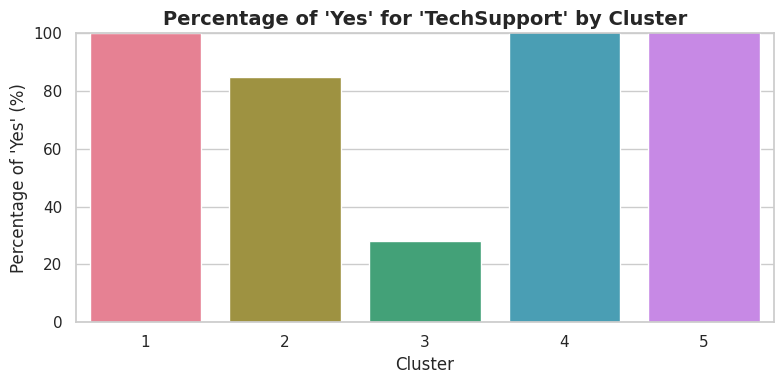

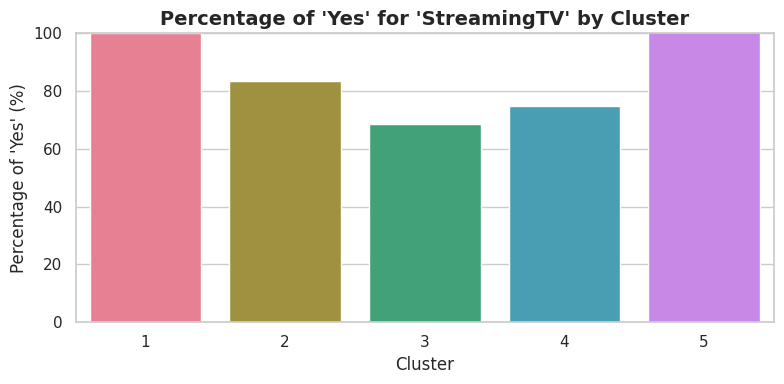

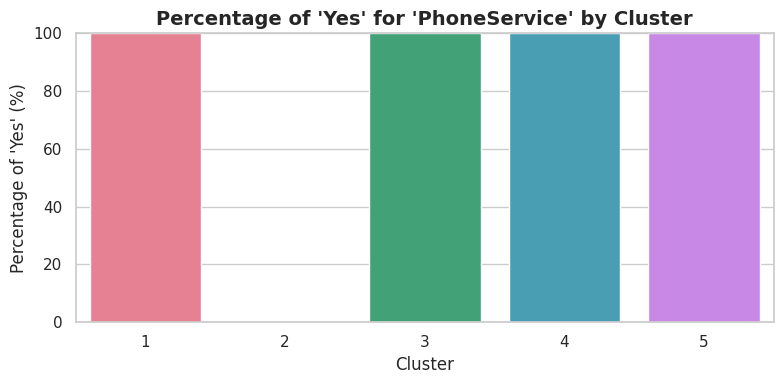

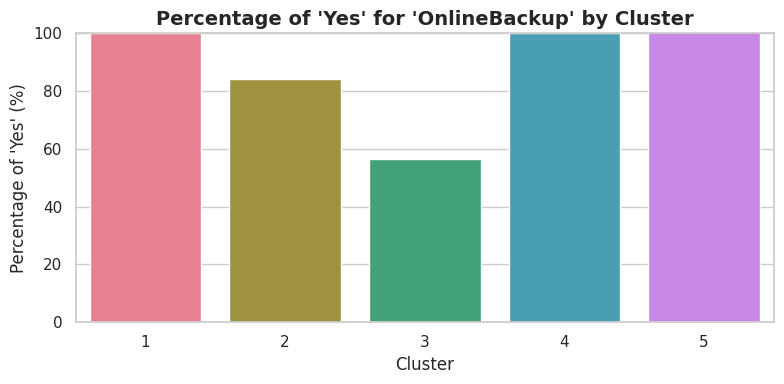

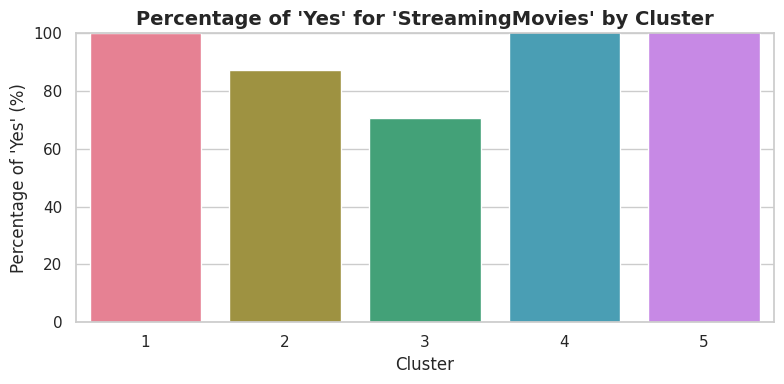

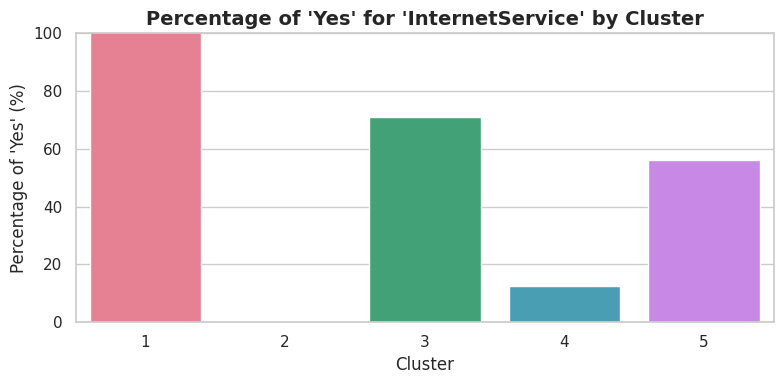

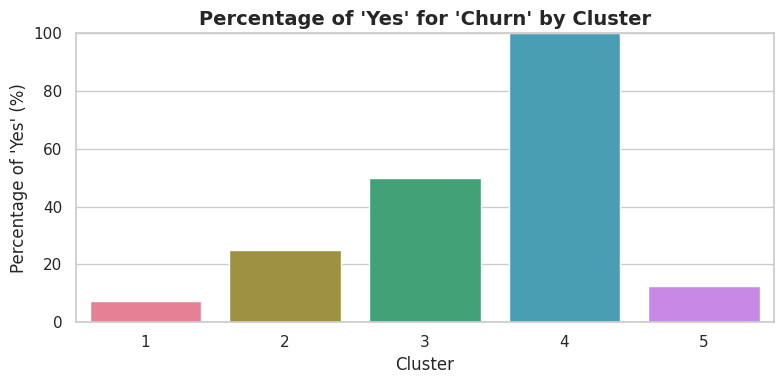

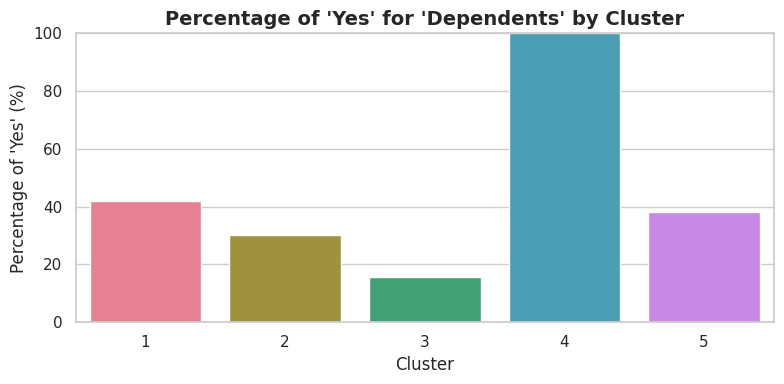

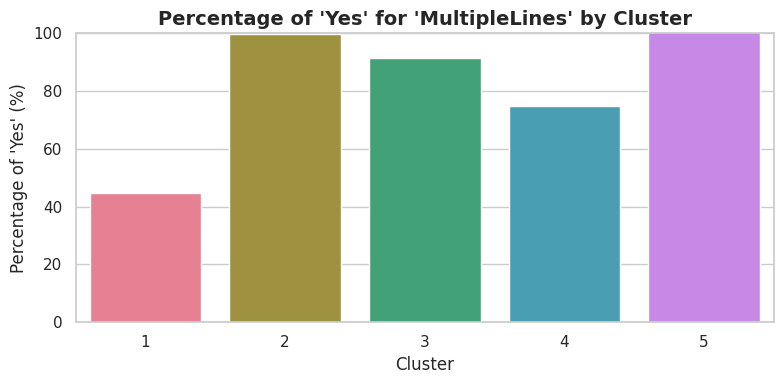

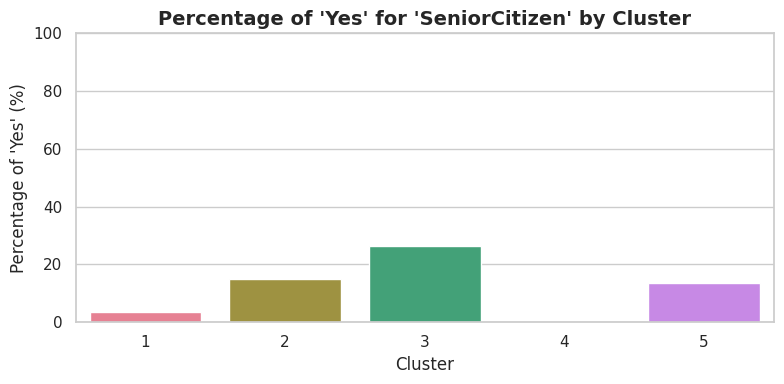

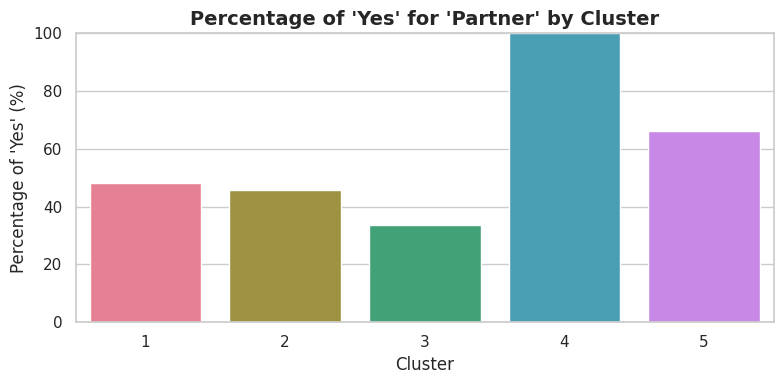

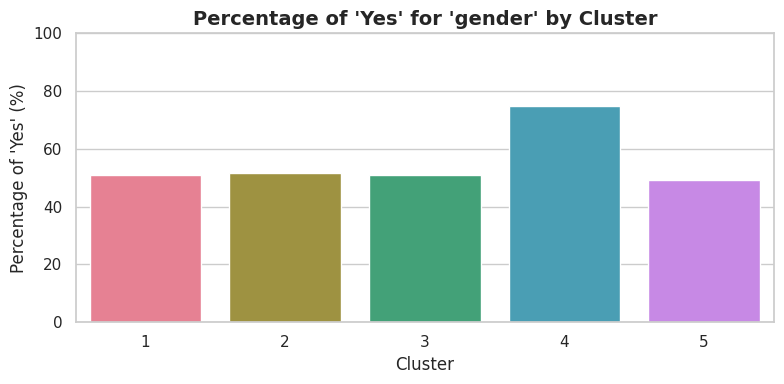

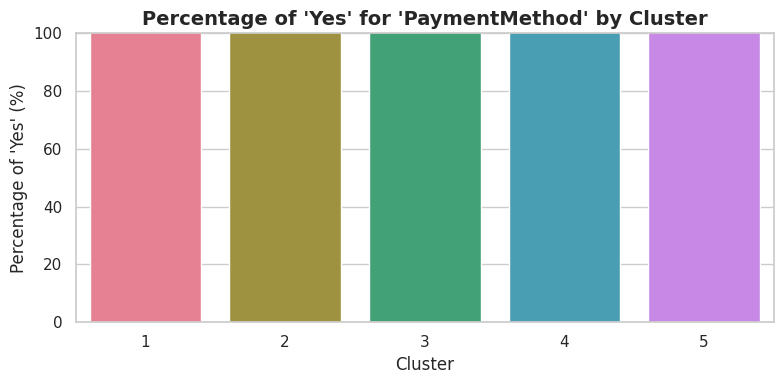

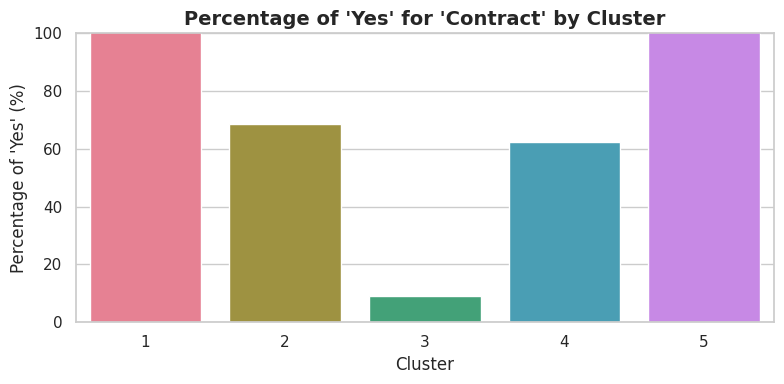

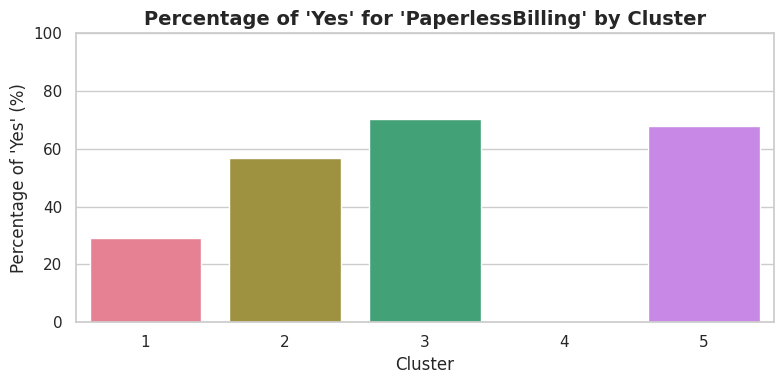

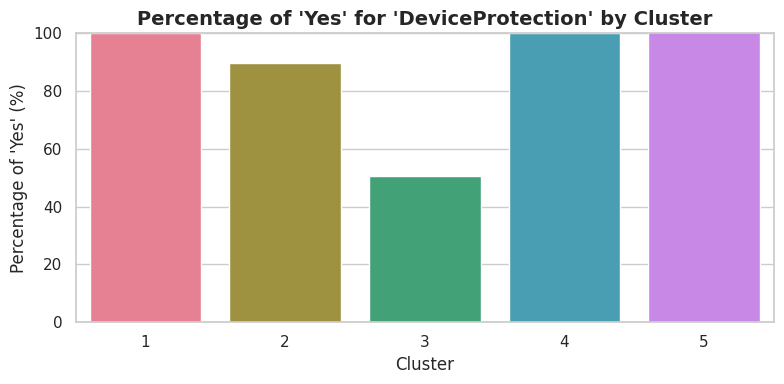

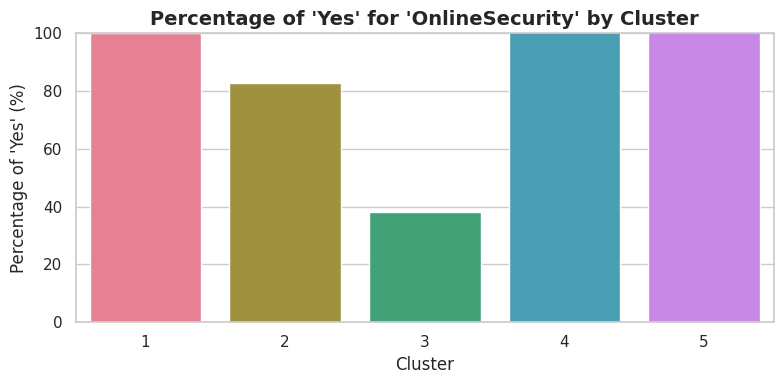

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load dataset ---
file_to_load = 'clustered_customers_k5.csv'  # Change as needed
df = pd.read_csv(file_to_load)

# --- Drop 'customerID' if present ---
if 'customerID' in df.columns:
    df.drop(columns='customerID', inplace=True)

# --- Ensure 'Cluster' is treated as categorical ---
cluster_col = 'Cluster'
df[cluster_col] = df[cluster_col].astype(str)

# --- Explicitly define numerical columns ---
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# --- All remaining columns are categorical (excluding 'Cluster') ---
all_columns = set(df.columns)
categorical_cols = list(all_columns - set(numerical_cols) - {cluster_col})

# --- Convert binary text to numeric (Yes/No to 1/0) ---
for col in categorical_cols:
    if set(df[col].dropna().unique()) <= {'Yes', 'No'}:
        df[col] = df[col].map({'Yes': 1, 'No': 0})
    elif set(df[col].dropna().unique()) <= {'True', 'False'}:
        df[col] = df[col].map({'True': 1, 'False': 0})

# --- Set up visual theme ---
sns.set(style="whitegrid")
palette = sns.color_palette("husl", df[cluster_col].nunique())  # Distinct cluster colors
title_font = {'fontsize': 14, 'fontweight': 'bold'}

# ==========================================
# NUMERICAL FEATURE ANALYSIS
# ==========================================
print("\n📊 Numerical Feature Plots\n" + "-" * 40)
for col in numerical_cols:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Summary stats
    summary_df = df.groupby(cluster_col)[col].agg(['mean', 'min', 'max']).reset_index()
    summary_df['range'] = summary_df['max'] - summary_df['min']

    # Mean plot
    sns.barplot(data=summary_df, x=cluster_col, y='mean', palette=palette, ax=axs[0])
    axs[0].set_title(f"Mean of '{col}' by Cluster", **title_font)
    axs[0].set_xlabel("Cluster")
    axs[0].set_ylabel("Mean")

    # Range plot
    sns.barplot(data=summary_df, x=cluster_col, y='range', palette=palette, ax=axs[1])
    axs[1].set_title(f"Range of '{col}' by Cluster (Max - Min)", **title_font)
    axs[1].set_xlabel("Cluster")
    axs[1].set_ylabel("Range")

    plt.tight_layout()
    plt.show()

# ==========================================
# CATEGORICAL FEATURE ANALYSIS
# ==========================================
print("\n📊 Categorical Feature Plots (Percent Yes)\n" + "-" * 40)
for col in categorical_cols:
    plt.figure(figsize=(8, 4))

    # Compute percentage of 1s per cluster
    percent_df = df.groupby(cluster_col)[col].mean().reset_index()
    percent_df[col] = percent_df[col] * 100  # convert to percentage

    sns.barplot(data=percent_df, x=cluster_col, y=col, palette=palette)
    plt.title(f"Percentage of 'Yes' for '{col}' by Cluster", **title_font)
    plt.ylabel("Percentage of 'Yes' (%)")
    plt.xlabel("Cluster")
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


In [2]:
import pandas as pd
import numpy as np
import gower
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import (
    normalized_mutual_info_score, adjusted_rand_score,
    homogeneity_score, completeness_score, v_measure_score,
    silhouette_score, calinski_harabasz_score, davies_bouldin_score
)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# --- Load dataset ---
df = pd.read_csv("/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv")
df = df.drop(columns=['customerID'])

# --- Encode categorical variables ---
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
df_encoded = df.copy()
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

# Store true labels for evaluation
true_labels = df_encoded['Churn']

# --- Compute Gower distance ---
print("Computing Gower distance matrix...")
gower_matrix = gower.gower_matrix(df)

# Convert to condensed form for clustering
gower_condensed = squareform(gower_matrix, checks=False)

# --- Hierarchical clustering ---
print("Performing hierarchical clustering...")
linkage_matrix = sch.linkage(gower_condensed, method='average')

# --- Clustering and Metric Evaluation ---
results = []

for k in range(2, 11):
    print(f"\nEvaluating clustering with k = {k}")
    cluster_labels = fcluster(linkage_matrix, t=k, criterion='maxclust')

    metrics = {}

    # External metrics (require true labels)
    metrics['k'] = k
    metrics["NMI"] = normalized_mutual_info_score(true_labels, cluster_labels)
    metrics["ARI"] = adjusted_rand_score(true_labels, cluster_labels)
    metrics["Homogeneity"] = homogeneity_score(true_labels, cluster_labels)
    metrics["Completeness"] = completeness_score(true_labels, cluster_labels)
    metrics["V-Measure"] = v_measure_score(true_labels, cluster_labels)

    # Internal metrics (on full dataset)
    try:
        metrics["Silhouette"] = silhouette_score(gower_matrix, cluster_labels, metric="precomputed")
    except:
        metrics["Silhouette"] = np.nan

    try:
        metrics["Calinski-Harabasz"] = calinski_harabasz_score(df_encoded.iloc[:, :-1], cluster_labels)
    except:
        metrics["Calinski-Harabasz"] = np.nan

    try:
        metrics["Davies-Bouldin"] = davies_bouldin_score(df_encoded.iloc[:, :-1], cluster_labels)
    except:
        metrics["Davies-Bouldin"] = np.nan

    # Approximate Compactness
    compactness = 0
    for label in np.unique(cluster_labels):
        idx = np.where(cluster_labels == label)[0]
        if len(idx) > 1:
            submat = gower_matrix[np.ix_(idx, idx)]
            upper_tri = submat[np.triu_indices(len(idx), k=1)]
            compactness += np.mean(upper_tri)
    compactness /= k
    metrics["Compactness"] = compactness

    # Inertia not available for hierarchical clustering
    metrics["Inertia"] = np.nan

    results.append(metrics)

# --- Show all results as a DataFrame ---
results_df = pd.DataFrame(results)

Computing Gower distance matrix...
Performing hierarchical clustering...

Evaluating clustering with k = 2

Evaluating clustering with k = 3

Evaluating clustering with k = 4

Evaluating clustering with k = 5

Evaluating clustering with k = 6

Evaluating clustering with k = 7

Evaluating clustering with k = 8

Evaluating clustering with k = 9

Evaluating clustering with k = 10


In [3]:
# Define metrics and their optimization direction
higher_is_better = [
    "NMI", "ARI", "Homogeneity", "Completeness", "V-Measure",
    "Silhouette", "Calinski-Harabasz"
]
lower_is_better = ["Davies-Bouldin", "Compactness"]

print("\n📊 Clustering Performance Ranking (Best k First):\n")

for metric in higher_is_better + lower_is_better:
    if metric not in results_df.columns:
        continue  # Skip missing metrics

    print(f"🔹 {metric} (Best {'↑' if metric in higher_is_better else '↓'}):")

    sorted_df = results_df[["k", metric]].dropna()

    if metric in higher_is_better:
        sorted_df = sorted_df.sort_values(by=metric, ascending=False)
    else:
        sorted_df = sorted_df.sort_values(by=metric, ascending=True)

    for i, row in sorted_df.iterrows():
        print(f"   k={int(row['k'])} → {metric} = {row[metric]:.4f}")
    
    print("-" * 50)



📊 Clustering Performance Ranking (Best k First):

🔹 NMI (Best ↑):
   k=9 → NMI = 0.0996
   k=5 → NMI = 0.0980
   k=10 → NMI = 0.0970
   k=4 → NMI = 0.0959
   k=8 → NMI = 0.0955
   k=7 → NMI = 0.0947
   k=6 → NMI = 0.0932
   k=2 → NMI = 0.0570
   k=3 → NMI = 0.0468
--------------------------------------------------
🔹 ARI (Best ↑):
   k=5 → ARI = 0.0512
   k=4 → ARI = 0.0499
   k=9 → ARI = 0.0343
   k=8 → ARI = 0.0339
   k=7 → ARI = 0.0338
   k=10 → ARI = 0.0303
   k=6 → ARI = 0.0269
   k=3 → ARI = -0.0487
   k=2 → ARI = -0.0654
--------------------------------------------------
🔹 Homogeneity (Best ↑):
   k=10 → Homogeneity = 0.1878
   k=9 → Homogeneity = 0.1878
   k=8 → Homogeneity = 0.1747
   k=7 → Homogeneity = 0.1731
   k=6 → Homogeneity = 0.1633
   k=5 → Homogeneity = 0.1589
   k=4 → Homogeneity = 0.1548
   k=3 → Homogeneity = 0.0564
   k=2 → Homogeneity = 0.0542
--------------------------------------------------
🔹 Completeness (Best ↑):
   k=5 → Completeness = 0.0709
   k=4 → Comp

> as per this 4 seems to be the best selection

### 4 and 5 cluster combinations have very similar metrics but we are choosimg 4 due to interpretability.


📁 Processing file: clustered_customers_k2.csv
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[291]	train's multi_logloss: 1.75966e-07	valid's multi_logloss: 1.75894e-07
📈 Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       305
           1       1.00      1.00      1.00      1104

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409

✔ Accuracy: 1.0000
✔ Macro F1 Score: 1.0000

🔍 Feature Importance (% of total gain):
         Feature   Percentage
 InternetService 1.000000e+02
          tenure 5.969414e-15
   SeniorCitizen 3.033250e-15
    TotalCharges 2.132941e-15
  MonthlyCharges 1.874942e-15
          gender 1.558100e-15
         Partner 7.278847e-16
      Dependents 5.668818e-16
 StreamingMovies 9.410537e-17
    PhoneService 2.499818e-17
   MultipleLines 2

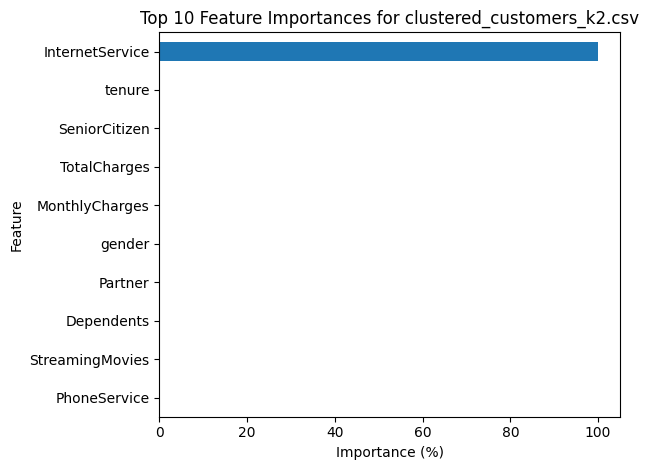


📁 Processing file: clustered_customers_k3.csv
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[474]	train's multi_logloss: 3.21925e-07	valid's multi_logloss: 7.55017e-07
📈 Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       305
           1       1.00      1.00      1.00       137
           2       1.00      1.00      1.00       967

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409

✔ Accuracy: 1.0000
✔ Macro F1 Score: 1.0000

🔍 Feature Importance (% of total gain):
         Feature  Percentage
 InternetService   35.484652
    PhoneService   33.397851
  MonthlyCharges   30.853978
    TotalCharges    0.098881
          tenure    0.063842
   SeniorCitizen    0.021078
  OnlineSecurity    0.016822
DeviceProtection    0.012963
 StreamingMovies    0.011586
    

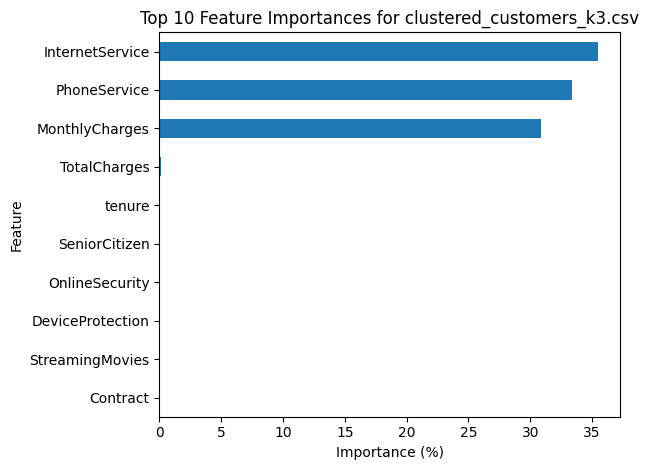


📁 Processing file: clustered_customers_k4.csv
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[167]	train's multi_logloss: 0.0359279	valid's multi_logloss: 0.13066
📈 Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       305
           1       1.00      1.00      1.00       137
           2       0.91      0.93      0.92       521
           3       0.92      0.89      0.91       446

    accuracy                           0.94      1409
   macro avg       0.96      0.96      0.96      1409
weighted avg       0.94      0.94      0.94      1409

✔ Accuracy: 0.9418
✔ Macro F1 Score: 0.9573

🔍 Feature Importance (% of total gain):
         Feature  Percentage
 InternetService   27.643257
    PhoneService   20.935667
  MonthlyCharges   19.074586
        Contract   15.764998
     TechSupport    3.077939
          tenure    2.296517
    TotalCharges    1.315196
      Dependen

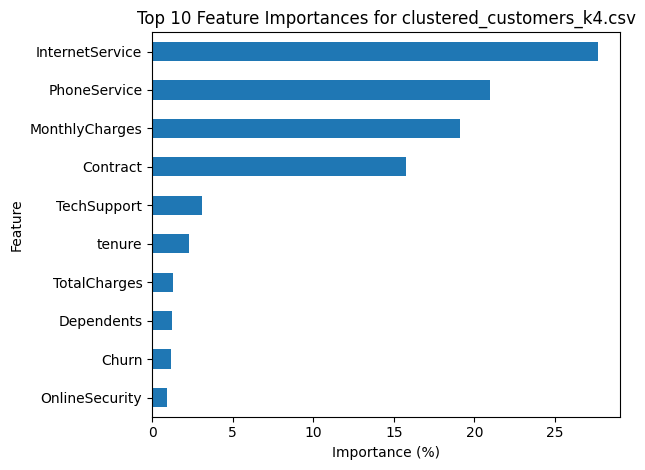


📁 Processing file: clustered_customers_k5.csv
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[187]	train's multi_logloss: 0.0279712	valid's multi_logloss: 0.136778
📈 Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       305
           1       1.00      1.00      1.00       137
           2       0.92      0.92      0.92       521
           3       1.00      0.50      0.67         2
           4       0.91      0.91      0.91       444

    accuracy                           0.94      1409
   macro avg       0.97      0.87      0.90      1409
weighted avg       0.94      0.94      0.94      1409

✔ Accuracy: 0.9411
✔ Macro F1 Score: 0.8989

🔍 Feature Importance (% of total gain):
         Feature  Percentage
 InternetService   27.416302
    PhoneService   20.868852
  MonthlyCharges   18.500415
        Contract   14.991899
     TechSupport    3.929947
          tenure 

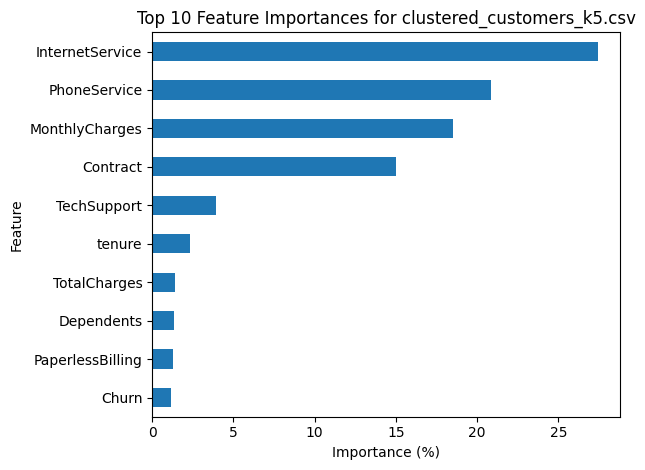

In [7]:
import pandas as pd
import numpy as np
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt

# --- Identify clustered files ---
clustered_files = sorted(glob.glob("clustered_customers_k*.csv"))

# --- Loop through each file and train model ---
for file in clustered_files:
    print(f"\n📁 Processing file: {file}")
    
    df = pd.read_csv(file)
    
    # Drop customerID if present
    df = df.drop(columns=['customerID'], errors='ignore')

    # Identify features
    target_col = 'Cluster'
    num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
    cat_cols = [col for col in df.columns if col not in num_cols + [target_col]]

    # Encode categorical variables
    df_encoded = df.copy()
    for col in cat_cols:
        df_encoded[col] = df_encoded[col].astype('category')

    # Ensure Cluster labels are 0-indexed
    df_encoded[target_col] = LabelEncoder().fit_transform(df_encoded[target_col])

    # Split data
    X = df_encoded.drop(columns=[target_col])
    y = df_encoded[target_col]
    
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # LightGBM Dataset
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
    val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols)

    # Model parameters
    params = {
        'objective': 'multiclass',
        'num_class': len(np.unique(y)),
        'metric': 'multi_logloss',
        'learning_rate': 0.05,
        'verbosity': -1,
        'seed': 42
    }

    # Train model with early stopping using callbacks
    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'valid'],
        num_boost_round=500,
        callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=True)]
    )

    # Predict and evaluate
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred_labels = np.argmax(y_pred, axis=1)

    print("📈 Model Performance:")
    print(classification_report(y_val, y_pred_labels))
    print(f"✔ Accuracy: {accuracy_score(y_val, y_pred_labels):.4f}")
    print(f"✔ Macro F1 Score: {f1_score(y_val, y_pred_labels, average='macro'):.4f}")

    # Feature importance
    importance = model.feature_importance(importance_type='gain')
    features = X.columns
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
    importance_df['Percentage'] = 100 * importance_df['Importance'] / importance_df['Importance'].sum()
    importance_df = importance_df.sort_values(by='Percentage', ascending=False)

    print("\n🔍 Feature Importance (% of total gain):")
    print(importance_df[['Feature', 'Percentage']].to_string(index=False))

    # Optional: plot top 10 features
    importance_df.head(10).plot(kind='barh', x='Feature', y='Percentage', legend=False)
    plt.title(f"Top 10 Feature Importances for {os.path.basename(file)}")
    plt.xlabel("Importance (%)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


## Latent Class Analysis (LCA)

In [1]:
!pip install stepmix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from stepmix.stepmix import StepMix

# Load dataset
df = pd.read_csv("/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv")

# Drop customerID and numerical columns
df = df.drop(columns=["customerID", "tenure", "MonthlyCharges", "TotalCharges"])

# Encode categorical variables numerically
label_encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Convert to numpy
X = df.values

# Store results
results = []

# Try cluster numbers from 2 to 5
for n_classes in range(2, 6):
    print(f"\nFitting LCA with {n_classes} classes...")
    model = StepMix(n_components=n_classes, measurement="categorical", n_steps=1, verbose=0, random_state=42)
    model.fit(X)
    
    bic = model.bic(X)
    aic = model.aic(X)
    ll = model.score(X)
    
    print(f"Log-Likelihood: {ll:.2f}, BIC: {bic:.2f}, AIC: {aic:.2f}")
    results.append((n_classes, ll, bic, aic))

# Display results summary
results_df = pd.DataFrame(results, columns=["Classes", "LogLikelihood", "BIC", "AIC"])
print("\n📊 LCA Model Comparison (2 to 5 classes):")
print(results_df.sort_values("BIC"))



Fitting LCA with 2 classes...
Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  5.07it/s, max_LL=-7.94e+4, max_avg_LL=-11.3]


Log-Likelihood: -11.27, BIC: 159318.92, AIC: 158927.91

Fitting LCA with 3 classes...
Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:01<00:00,  1.06s/it, max_LL=-7.57e+4, max_avg_LL=-10.7]


Log-Likelihood: -10.74, BIC: 152106.82, AIC: 151516.88

Fitting LCA with 4 classes...
Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, max_LL=-7.33e+4, max_avg_LL=-10.4]


Log-Likelihood: -10.41, BIC: 147686.09, AIC: 146897.21

Fitting LCA with 5 classes...
Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, max_LL=-7.23e+4, max_avg_LL=-10.3]

Log-Likelihood: -10.26, BIC: 145778.52, AIC: 144790.71

📊 LCA Model Comparison (2 to 5 classes):
   Classes  LogLikelihood            BIC            AIC
3        5     -10.258605  145778.522711  144790.713023
2        4     -10.412268  147686.085973  146897.210181
1        3     -10.744348  152106.820993  151516.879097
0        2     -11.274592  159318.917252  158927.909251


In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from stepmix.stepmix import StepMix

# -----------------------------
# Load full dataset
# -----------------------------
full_df = pd.read_csv("/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv")

# -----------------------------
# Select only categorical columns for LCA
# -----------------------------
categorical_df = full_df.drop(columns=["customerID", "tenure", "MonthlyCharges", "TotalCharges"])
categorical_df = categorical_df.astype(str)

# Encode categorical variables numerically
label_encoders = {}
for col in categorical_df.columns:
    le = LabelEncoder()
    categorical_df[col] = le.fit_transform(categorical_df[col])
    label_encoders[col] = le

# Convert to numpy
X = categorical_df.values

# -----------------------------
# Fit LCA (Latent Class Analysis)
# -----------------------------
print("\nFitting LCA with 5 classes...")
model = StepMix(n_components=5, measurement="categorical", n_steps=1, verbose=0, random_state=42)
model.fit(X)

# -----------------------------
# Predict cluster labels and append to original DataFrame
# -----------------------------
full_df['Cluster'] = model.predict(X)

# -----------------------------
# Save to file with all original columns + Cluster
# -----------------------------
output_path = "clustered_customer_data.csv"
full_df.to_csv(output_path, index=False)
print(f"\n✅ Clustered data saved to: {output_path}")



Fitting LCA with 5 classes...
Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, max_LL=-7.23e+4, max_avg_LL=-10.3]


✅ Clustered data saved to: clustered_customer_data.csv
